# BEMB Demo: Simulation Studies.

> Author: Tianyu Du (tianyudu@stanford.edu)

This notebook contains replication materials for the simulation studies in the BEMB paper;

Before running this notebook, you should create a folder called, to save simulation results (e.g., figures). Please modify the `OUTPUT_DIR` variable below to point to the folder you just created.

In [1]:
import os
OUTPUT_DIR = "./paper_demo_simulation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Setup.

In [2]:
# Standard library imports
import random
from typing import List

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from torch_choice.data import ChoiceDataset
from tqdm import tqdm

# Local imports
from bemb.model import LitBEMBFlex

In [3]:
# Fix Random Seeds for Reproducibility.
random.seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

In [4]:
# Please note that `mps` (apple silicon gpus) is not fully supported by PyTorch; therefore, you would need to use `cpu` device on Mac.
if torch.cuda.is_available():
    DEVICE = "cuda"
    try:
        # control the precision of GPU-based operations.
        torch.set_float32_matmul_precision("high")
    except:
        pass
else:
    DEVICE = "cpu"
print(f"Using {DEVICE} device with torch version {torch.__version__} and name {torch.cuda.get_device_name(DEVICE)}")

Using cuda device with torch version 2.5.1+cu124 and name NVIDIA GeForce RTX 3090


In [5]:
# control the quality of figures. Use 75 for preview, use 300 for publication.
# using a larger DPI will increase the file size of the figure and the time to render the figure.
DPI = 300

In [6]:
# configure the size of simulation.
num_users = 1_500  # 1500 users in the dataset.
num_items = 50  # 50 items to choose from.
num_sessions = 10  # 10 sessions; sessions are used only in simulation 4.
data_size = 50_000  # 10,000 choice records.

# New Simulation Studies introduced in 2025 Revision.
## Data Generation Process

In [7]:
np.var(np.random.gumbel(0, 0.3, size=(num_users, 1)))

0.15879964269152996

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import torch
from torch_choice.data import ChoiceDataset

# Define the data generation function
def generate_simulation_data(
    num_users, num_items, num_sessions, data_size,
    K_u, K_i, R_latent_dim,
    sigma_cluster_u, sigma_user, sigma_cluster_i, sigma_item,
    delta_0, delta_1, sigma_P, sigma_P_session,
    demand_effect,
    sigma_alpha, sigma_beta,
    direct_pref_weight, gamma, sigma_U,
    *, # Make subsequent arguments keyword-only
    seed,
    price_dynamic_session: bool = False,
    price_user_specific: bool = False
):
    """
    Generates simulated data for dynamic pricing and choice modeling.

    Args:
        num_users (int): Number of users.
        num_items (int): Number of items.
        num_sessions (int): Number of sessions.
        data_size (int): Total number of choice records to generate.
        K_u (int): Number of user clusters.
        K_i (int): Number of item clusters.
        R_latent_dim (int): Latent dimension for user and item factors.
        sigma_cluster_u (float): Std dev for user cluster means.
        sigma_user (float): Within-user-cluster noise std dev for latent factors.
        sigma_cluster_i (float): Std dev for item cluster means.
        sigma_item (float): Within-item-cluster noise std dev for latent factors.
        delta_0 (float): Baseline offer (price) level.
        delta_1 (float): Scaling factor for user-item latent interaction effect on price
                         (only if price_user_specific=True).
        sigma_P (float): Noise std dev for the offer (price).
        sigma_P_session (float): Session-specific variation std dev for the base offer level.
        demand_effect (float): Coefficient for how previous session demand affects price
                               (only if price_dynamic_session=True).
        sigma_alpha (float): User fixed effect std dev.
        sigma_beta (float): Item fixed effect std dev.
        direct_pref_weight (float): Direct weight of user-item preference match (M_ui) in utility.
        gamma (float): Price sensitivity coefficient in utility.
        sigma_U (float): Noise std dev for the utility.
        seed (int): Random seed for reproducibility.
        price_dynamic_session (bool, optional): If True, prices change across sessions based on
                                                previous session's demand. Defaults to False
                                                (prices fixed across sessions, subject to initial
                                                 session-specific variation if num_sessions > 1).
        price_user_specific (bool, optional): If True, prices are personalized for each user
                                              (i.e., depend on user-item latent interaction F_M_matrix).
                                              Defaults to False (prices are uniform for all users,
                                              varying only by item and potentially session).
    """
    np.random.seed(seed)

    # Helper functions
    def nonlinear_transform(x_val):
        # return x_val
        return np.sign(x_val) * np.log(1 + np.abs(x_val))
        # return np.sign(x_val) * np.abs(x_val) ** 3

    def softmax(x_arr):
        # Subtract max for numerical stability
        ex_arr = np.exp(x_arr - np.max(x_arr))
        sum_ex_arr = np.sum(ex_arr)
        if sum_ex_arr == 0: # Handle underflow case by assigning uniform probability
            return np.ones_like(ex_arr) / len(ex_arr)
        return ex_arr / sum_ex_arr

    # ----------------------------------------------------------------------------------------------------------------------
    # 1. Generate User and Item Latent Factors with Clustering
    # ----------------------------------------------------------------------------------------------------------------------

    user_clusters_arr = np.random.choice(K_u, size=num_users)
    cluster_means_users = np.random.normal(0, sigma_cluster_u, size=(K_u, R_latent_dim))
    theta_matrix = np.array([
        cluster_means_users[user_clusters_arr[u]] + np.random.normal(0, sigma_user, size=R_latent_dim)
        for u in range(num_users)
    ])


    item_clusters_arr = np.random.choice(K_i, size=num_items)
    cluster_means_items = np.random.normal(0, sigma_cluster_i, size=(K_i, R_latent_dim))
    eta_matrix = np.array([
        cluster_means_items[item_clusters_arr[i]] + np.random.normal(0, sigma_item, size=R_latent_dim)
        for i in range(num_items)
    ])


    # ----------------------------------------------------------------------------------------------------------------------
    # 2. Compute the Base User-Item Interaction Matrix
    # ----------------------------------------------------------------------------------------------------------------------
    M_matrix = theta_matrix.dot(eta_matrix.T)  # shape: (num_users, num_items)
    M_target_variance = 5.0
    M_matrix *= np.sqrt(M_target_variance / np.var(M_matrix))
    F_M_matrix = nonlinear_transform(M_matrix) # Transformed interaction, used for price if user-specific

    # ----------------------------------------------------------------------------------------------------------------------
    # 3. Generate Fixed Effects for Users and Items
    # ----------------------------------------------------------------------------------------------------------------------
    alpha_arr = np.random.normal(0, sigma_alpha, size=num_users)  # user fixed effects
    beta_arr = np.random.normal(0, sigma_beta, size=num_items)    # item fixed effects

    # ----------------------------------------------------------------------------------------------------------------------
    # 4. Generate the Price Tensor P_tensor (num_sessions, num_users, num_items)
    # ----------------------------------------------------------------------------------------------------------------------
    P_tensor = np.zeros((num_sessions, num_users, num_items))

    # --- Determine Price for the First Session (s=0) ---
    # Base price level for session 0, incorporates session-specific variation from delta_0
    base_price_s0 = delta_0 + np.random.normal(0, sigma_P_session)

    # User-specific component of price (from F_M_matrix), active if price_user_specific is True
    user_specific_price_component = np.zeros((num_users, num_items))
    if price_user_specific:
        user_specific_price_component = delta_1 * F_M_matrix

    # Noise component for price in session 0
    if price_user_specific:
        # User-item specific noise
        price_noise_s0 = np.random.normal(0, sigma_P, size=(num_users, num_items))
    else:
        # Item-specific noise, broadcast to all users
        price_noise_s0 = np.random.normal(0, sigma_P, size=(1, num_items))

    P_tensor[0] = base_price_s0 + user_specific_price_component + price_noise_s0

    # --- Determine Prices for Subsequent Sessions (s > 0) ---
    if not price_dynamic_session:
        # If prices are not dynamic, they are fixed across sessions (copy P_tensor[0])
        for s_idx in range(1, num_sessions):
            P_tensor[s_idx] = P_tensor[0]
    # If price_dynamic_session is True, P_tensor for s > 0 will be computed in the loop below.


    # ----------------------------------------------------------------------------------------------------------------------
    # 5. Generate the Utility Matrix U and Update Prices Dynamically if applicable
    # ----------------------------------------------------------------------------------------------------------------------
    U_tensor = np.zeros((num_sessions, num_users, num_items))

    for s_iter in range(num_sessions):
        # Generate Utility for current session s_iter using P_tensor[s_iter]
        U_tensor[s_iter] = (alpha_arr[:, np.newaxis] + beta_arr[np.newaxis, :]    # Fixed effects
                            + direct_pref_weight * M_matrix                      # Base preference
                            + gamma * P_tensor[s_iter]                           # Price effect
                            + np.random.gumbel(0, 0.3, size=(num_users, num_items))) # Utility noise

        # U_tensor[s_iter] = direct_pref_weight * M_matrix + gamma * P_tensor[s_iter] + np.random.gumbel(0, 1, size=(num_users, num_items))

        # If prices are dynamic and this is not the last session, update price for the NEXT session (s_iter+1)
        if price_dynamic_session and (s_iter < num_sessions - 1):
            # Calculate expected demand from U_tensor[s_iter]
            U_s_iter_max_per_choice_set = np.max(U_tensor[s_iter], axis=1, keepdims=True)
            exp_U_s_iter_stable = np.exp(U_tensor[s_iter] - U_s_iter_max_per_choice_set)
            sum_exp_U_s_iter_stable = np.sum(exp_U_s_iter_stable, axis=1, keepdims=True) # Shape: (num_users, 1)

            prob_choice_s_iter = np.zeros_like(exp_U_s_iter_stable) # Shape: (num_users, num_items)

            # Avoid division by zero if sum_exp_U_s_iter_stable is zero for some choice sets.
            # valid_denom_condition is a 2D boolean array of shape (num_users, 1).
            valid_denom_condition = sum_exp_U_s_iter_stable != 0

            # Convert to a 1D boolean mask of shape (num_users,) for row-wise indexing.
            # The previous reshape `valid_denom = valid_denom.reshape(-1, 1)` was redundant and
            # did not create the correct mask shape for row-wise boolean indexing.
            valid_rows_mask = valid_denom_condition.squeeze(axis=1) # Shape: (num_users,)

            # Calculate probabilities for rows where the denominator is non-zero.
            # exp_U_s_iter_stable[valid_rows_mask] has shape (k, num_items)
            # sum_exp_U_s_iter_stable[valid_rows_mask] has shape (k, 1), which broadcasts correctly.
            prob_choice_s_iter[valid_rows_mask] = (exp_U_s_iter_stable[valid_rows_mask] /
                                                   sum_exp_U_s_iter_stable[valid_rows_mask])

            # For choice sets where all utilities were extremely negative (sum_exp is 0), assign uniform probability.
            prob_choice_s_iter[~valid_rows_mask] = 1.0 / num_items

            expected_demand_s_iter = np.sum(prob_choice_s_iter, axis=0)  # shape: (num_items,)

            # Standardize expected demand
            mean_demand = np.mean(expected_demand_s_iter)
            std_demand = np.std(expected_demand_s_iter)
            standardized_demand = np.zeros_like(expected_demand_s_iter)
            if std_demand != 0:
                standardized_demand = (expected_demand_s_iter - mean_demand) / std_demand

            price_demand_update = demand_effect * standardized_demand  # Shape (num_items,)

            # Base price level for the next session (s_iter+1)
            base_price_s_next = delta_0 + np.random.normal(0, sigma_P_session)

            # Noise component for price in the next session
            if price_user_specific:
                price_noise_s_next = np.random.normal(0, sigma_P, size=(num_users, num_items))
            else:
                price_noise_s_next = np.random.normal(0, sigma_P, size=(1, num_items))

            # Update P_tensor for the next session
            # user_specific_price_component is the same as for s=0 (depends on F_M_matrix)
            P_tensor[s_iter+1] = (base_price_s_next +
                                  user_specific_price_component +
                                  price_demand_update[np.newaxis, :] + # Broadcast demand update to users
                                  price_noise_s_next)

    # ----------------------------------------------------------------------------------------------------------------------
    # 6. Sample Purchase Records via a Softmax over U and Track Demand
    # ----------------------------------------------------------------------------------------------------------------------
    sampled_sessions_indices = np.random.choice(num_sessions, size=data_size)
    sampled_users_indices = np.random.choice(num_users, size=data_size)
    sampled_items_indices = np.empty(data_size, dtype=int)

    for i_obs in range(data_size):
        s_obs = sampled_sessions_indices[i_obs]
        u_obs = sampled_users_indices[i_obs]
        probs = softmax(U_tensor[s_obs, u_obs, :])
        # Ensure probabilities sum to 1 (can have small numerical errors or all-zero from underflow)
        # Softmax helper already handles sum_probs approx 0.
        # sum_probs = np.sum(probs)
        # if sum_probs > 0:
        #      probs /= sum_probs
        # else: # if all utilities are extremely negative, softmax might output all zeros. Assign uniform.
        #     probs = np.ones(num_items) / num_items
        item_obs = np.random.choice(num_items, p=probs)
        # Take argmax instead of sampling
        sampled_items_indices[i_obs] = item_obs

    records = {
        'session': sampled_sessions_indices,
        'user': sampled_users_indices,
        'item': sampled_items_indices,
        'user_cluster': user_clusters_arr[sampled_users_indices],
        'item_cluster': item_clusters_arr[sampled_items_indices],
        'M_ui': M_matrix[sampled_users_indices, sampled_items_indices],
        'f_M_ui': F_M_matrix[sampled_users_indices, sampled_items_indices],
        'P_uis': np.array([P_tensor[s, u, i] for s, u, i in zip(sampled_sessions_indices, sampled_users_indices, sampled_items_indices)]),
        'U_uis': np.array([U_tensor[s, u, i] for s, u, i in zip(sampled_sessions_indices, sampled_users_indices, sampled_items_indices)])
    }
    df_purchases_out = pd.DataFrame(records)

    purchases_per_session_out = np.zeros((num_sessions, num_items))
    for s_calc in range(num_sessions):
        for i_calc in range(num_items):
            purchases_per_session_out[s_calc, i_calc] = np.sum((sampled_sessions_indices == s_calc) & (sampled_items_indices == i_calc))

    user_index = torch.LongTensor(df_purchases_out['user'].values)
    item_index = torch.LongTensor(df_purchases_out['item'].values)
    session_index = torch.LongTensor(df_purchases_out['session'].values)

    user_cluster = torch.LongTensor(df_purchases_out['user_cluster'].values)
    item_cluster = torch.LongTensor(df_purchases_out['item_cluster'].values)
    M_ui_tensor = torch.FloatTensor(df_purchases_out['M_ui'].values)
    f_M_ui_tensor = torch.FloatTensor(df_purchases_out['f_M_ui'].values)
    P_uis_tensor = torch.FloatTensor(df_purchases_out['P_uis'].values)
    U_uis_tensor = torch.FloatTensor(df_purchases_out['U_uis'].values)

    # usersessionitem_obs = torch.stack([
    #     user_cluster.float(),
    #     item_cluster.float(),
    #     M_ui_tensor,
    #     f_M_ui_tensor,
    #     P_uis_tensor,
    #     U_uis_tensor
    # ], dim=1)

    P_tensor_usi = torch.FloatTensor(P_tensor).permute(1, 0, 2).unsqueeze(-1)
    assert P_tensor_usi.shape == (num_users, num_sessions, num_items, 1)

    dataset = ChoiceDataset(
        user_index=user_index,
        item_index=item_index,
        session_index=session_index,
        num_users=num_users,
        num_items=num_items,
        num_sessions=num_sessions,
        item_availability=None, # Assuming all items available in all sessions for simplicity
        usersessionitem_price=P_tensor_usi,
        useritem_M=torch.FloatTensor(M_matrix).unsqueeze(-1),
        user_matrix=torch.FloatTensor(alpha_arr).unsqueeze(-1),
        item_matrix=torch.FloatTensor(beta_arr).unsqueeze(-1),
    )

    print(dataset)

    def split_dataset(D, train_frac=0.8, val_frac=0.1):
        num_samples = len(D)
        indices = np.random.permutation(num_samples)
        train_end = int(train_frac * num_samples)
        val_end = int((train_frac + val_frac) * num_samples)

        train_idx = indices[:train_end]
        val_idx = indices[train_end:val_end]
        test_idx = indices[val_end:]

        return [D[train_idx], D[val_idx], D[test_idx]]

    dataset_list = [d.to(DEVICE) for d in split_dataset(dataset)]

    print(f"Training set: {len(dataset_list[0])} samples")
    print(f"Validation set: {len(dataset_list[1])} samples")
    print(f"Test set: {len(dataset_list[2])} samples")

    simulation_config = {
        'num_users': num_users, 'num_items': num_items, 'num_sessions': num_sessions, 'data_size': data_size,
        'K_u': K_u, 'K_i': K_i, 'R_latent_dim': R_latent_dim,
        'sigma_cluster_u': sigma_cluster_u, 'sigma_user': sigma_user, 'sigma_cluster_i': sigma_cluster_i, 'sigma_item': sigma_item,
        'delta_0': delta_0, 'delta_1': delta_1, 'sigma_P': sigma_P, 'sigma_P_session': sigma_P_session,
        'demand_effect': demand_effect,
        'sigma_alpha': sigma_alpha, 'sigma_beta': sigma_beta,
        'direct_pref_weight': direct_pref_weight, 'gamma': gamma, 'sigma_U': sigma_U,
        'seed': seed,
        'price_dynamic_session': price_dynamic_session,
        'price_user_specific': price_user_specific
    }

    return {
        "df_purchases": df_purchases_out,
        "purchases_per_session": purchases_per_session_out,
        "P": P_tensor,
        "U": U_tensor,
        "M": M_matrix,
        "F_M": F_M_matrix,
        "user_clusters": user_clusters_arr,
        "item_clusters": item_clusters_arr,
        "alpha": alpha_arr,
        "beta": beta_arr,
        "theta": theta_matrix,
        "eta": eta_matrix,
        "dataset_list": dataset_list,
        "device": dataset_list[0].device,
        "simulation_config": simulation_config
    }

## Visualization Helper Functions

In [9]:
def visualize_simulation_results(simulation_results) -> None:
    # Helper function to safely convert to NumPy array
    def _to_numpy(data_element):
        # Check if torch is available (it should be in the notebook environment)
        if 'torch' in globals() and isinstance(data_element, torch.Tensor):
            return data_element.cpu().numpy()
        return data_element

    # Unpack results from the simulation_results dictionary
    df_purchases = simulation_results["df_purchases"]
    purchases_per_session = simulation_results["purchases_per_session"]
    P = simulation_results["P"]
    U = simulation_results["U"]
    M = simulation_results["M"]
    F_M = simulation_results["F_M"]
    user_clusters = simulation_results["user_clusters"]
    item_clusters = simulation_results["item_clusters"]
    alpha = simulation_results["alpha"]
    beta = simulation_results["beta"]
    theta = simulation_results["theta"]
    eta = simulation_results["eta"]
    dataset_list = simulation_results["dataset_list"]
    device = simulation_results["device"]
    simulation_params = simulation_results["simulation_config"]

    # Extract necessary parameters from simulation_params
    num_users = simulation_params['num_users']
    num_items = simulation_params['num_items']
    num_sessions = simulation_params['num_sessions']
    K_i = simulation_params['K_i']
    K_u = simulation_params['K_u']
    R_latent_dim = simulation_params['R_latent_dim']


    # Set professional plotting style
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

    # Create a figure with multiple subplots for comprehensive visualization
    # Increased figure height and added a row to GridSpec for latent factor plots
    fig = plt.figure(figsize=(20, 21)) # Adjusted height from 16 to 21
    gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1.2, 1]) # 3 rows -> 4 rows

    # 1. Price Distribution by Session
    ax1 = fig.add_subplot(gs[0, 0])

    # Create violin plots for price distribution across sessions
    session_prices = [df_purchases[df_purchases['session'] == s]['P_uis'] for s in range(num_sessions)]
    if any(len(sp) > 0 for sp in session_prices): # Check if there's data to plot
        violin_parts = ax1.violinplot(session_prices, showmeans=True, showmedians=True)

        # Customize violin plot appearance
        for pc in violin_parts['bodies']:
            pc.set_facecolor('#3498db')
            pc.set_edgecolor('#2c3e50')
            pc.set_alpha(0.7)

        for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians']:
            if partname in violin_parts:
                vp = violin_parts[partname]
                vp.set_edgecolor('#2c3e50')
                vp.set_linewidth(1.5)
    else:
        ax1.text(0.5, 0.5, "No price data available for sessions.",
                 horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


    # Add styling
    ax1.set_xlabel('Session', fontweight='bold')
    ax1.set_ylabel('Price', fontweight='bold')
    ax1.set_title('Price Distribution Across Sessions', fontsize=16, fontweight='bold')
    if num_sessions > 0:
        ax1.set_xticks(np.arange(1, num_sessions+1))
    ax1.grid(True, alpha=0.3, linestyle='-.')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # 2. Price Heatmap by Item Cluster and Session
    ax2 = fig.add_subplot(gs[0, 1])

    # Calculate average price per session and item cluster
    if num_sessions > 0 and K_i > 0:
        price_by_cluster_session = np.full((num_sessions, K_i), np.nan) # Initialize with NaN
        for s in range(num_sessions):
            for ic in range(K_i):
                session_cluster_prices = df_purchases[(df_purchases['session'] == s) &
                                                    (df_purchases['item_cluster'] == ic)]['P_uis']
                if len(session_cluster_prices) > 0:
                    price_by_cluster_session[s, ic] = session_cluster_prices.mean()

        # Create heatmap
        im = ax2.imshow(price_by_cluster_session, cmap='viridis', aspect='auto', interpolation='nearest')
        cbar = plt.colorbar(im, ax=ax2)
        cbar.set_label('Average Price', fontweight='bold')

        # Add text annotations with actual values
        # Calculate mean for color decision, ignoring NaNs
        mean_price_for_color = np.nanmean(price_by_cluster_session) if not np.all(np.isnan(price_by_cluster_session)) else 0

        for s_idx in range(num_sessions): # Renamed s to s_idx to avoid conflict
            for ic_idx in range(K_i): # Renamed ic to ic_idx
                val = price_by_cluster_session[s_idx, ic_idx]
                if not np.isnan(val):
                    text_color = "white" if val > mean_price_for_color else "black"
                    # Adjust text color if background is too dark/light for default choice
                    # This is a heuristic, proper luminance calculation would be more robust
                    if im.cmap(im.norm(val))[3] > 0.5 and val > mean_price_for_color : # if background is light and text is white
                         text_color = "black"
                    elif im.cmap(im.norm(val))[3] < 0.5 and val <= mean_price_for_color : # if background is dark and text is black
                         text_color = "white"

                    ax2.text(ic_idx, s_idx, f"{val:.1f}",
                            ha="center", va="center",
                            color=text_color,
                            fontweight='bold', fontsize=9)
    else:
        ax2.text(0.5, 0.5, "Not enough sessions or item clusters for heatmap.",
                 horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


    # Add styling
    ax2.set_xlabel('Item Cluster', fontweight='bold')
    ax2.set_ylabel('Session', fontweight='bold')
    ax2.set_title('Average Price by Item Cluster and Session', fontsize=16, fontweight='bold')
    if K_i > 0:
        ax2.set_xticks(np.arange(K_i))
        ax2.set_xticklabels([f'Cluster {i}' for i in range(K_i)])
    if num_sessions > 0:
        ax2.set_yticks(np.arange(num_sessions))
        ax2.set_yticklabels([f'Session {i}' for i in range(num_sessions)])


    # 3. Price vs. Demand Scatter Plot
    ax3 = fig.add_subplot(gs[1, 0])

    # Calculate average price and demand for each item in each session
    price_demand_data = []
    if num_sessions > 0 and num_items > 0 and P is not None and purchases_per_session is not None and \
       item_clusters is not None and len(item_clusters) == num_items and \
       _to_numpy(P).shape[0] == num_sessions and _to_numpy(P).shape[2] == num_items and \
       _to_numpy(purchases_per_session).shape[0] == num_sessions and _to_numpy(purchases_per_session).shape[1] == num_items:

        P_np = _to_numpy(P)
        purchases_per_session_np = _to_numpy(purchases_per_session)

        for s_idx in range(num_sessions): # Renamed s to s_idx
            for i_idx in range(num_items): # Renamed i to i_idx
                avg_price = np.mean(P_np[s_idx, :, i_idx])
                demand = purchases_per_session_np[s_idx, i_idx]
                price_demand_data.append({
                    'session': s_idx,
                    'item': i_idx,
                    'item_cluster': item_clusters[i_idx], # item_clusters is already a numpy array
                    'avg_price': avg_price,
                    'demand': demand
                })
    price_demand_df = pd.DataFrame(price_demand_data)

    if not price_demand_df.empty:
        # Create scatter plot with regression line for each session
        sessions_to_show = [0, num_sessions // 4, num_sessions // 2, 3 * num_sessions // 4, num_sessions - 1]
        sessions_to_show = sorted(list(set(s for s in sessions_to_show if 0 <= s < num_sessions))) # Ensure valid and unique
        if not sessions_to_show and num_sessions > 0:
            sessions_to_show = [0]

        colors = plt.cm.viridis(np.linspace(0, 1, len(sessions_to_show)))

        for idx, s_val in enumerate(sessions_to_show): # Renamed s to s_val
            session_data = price_demand_df[price_demand_df['session'] == s_val]
            if not session_data.empty:
                ax3.scatter(
                    session_data['avg_price'],
                    session_data['demand'],
                    s=80,
                    alpha=0.7,
                    color=colors[idx],
                    edgecolor='w',
                    linewidth=0.5,
                    label=f'Session {s_val}'
                )

                # Add regression line
                if len(session_data) > 1:  # Need at least 2 points for regression
                    x_val = session_data['avg_price']
                    y_val = session_data['demand']
                    z = np.polyfit(x_val, y_val, 1)
                    p_poly = np.poly1d(z)
                    ax3.plot(
                        np.sort(x_val),
                        p_poly(np.sort(x_val)),
                        '--',
                        color=colors[idx],
                        linewidth=2
                    )
        if sessions_to_show:
            ax3.legend(loc='best', frameon=True, framealpha=0.9)
    else:
        ax3.text(0.5, 0.5, "No data for price-demand plot.",
                 horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)


    # Add styling
    ax3.set_xlabel('Average Price', fontweight='bold')
    ax3.set_ylabel('Demand (Number of Purchases)', fontweight='bold')
    ax3.set_title('Price-Demand Relationship by Session', fontsize=16, fontweight='bold')
    ax3.grid(True, alpha=0.3, linestyle='-.')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)


    # 4. Price Trend for Selected Items
    ax4 = fig.add_subplot(gs[1, 1])

    selected_items = []
    if K_i > 0 and num_items > 0 and item_clusters is not None and len(item_clusters) == num_items:
        for ic_idx in range(min(K_i, 5)):  # Select one item from each cluster (up to 5)
            cluster_items_indices = np.where(item_clusters == ic_idx)[0]
            if len(cluster_items_indices) > 0:
                selected_items.append(cluster_items_indices[0])

    if selected_items and num_sessions > 0 and P is not None and \
       _to_numpy(P).shape[0] == num_sessions and _to_numpy(P).shape[2] == num_items:
        P_np = _to_numpy(P)
        for item_idx_val in selected_items: # Renamed item_idx to item_idx_val
            item_prices = [np.mean(P_np[s, :, item_idx_val]) for s in range(num_sessions)]
            ax4.plot(
                range(num_sessions),
                item_prices,
                'o-',
                linewidth=2.5,
                markersize=8,
                label=f'Item {item_idx_val} (Cluster {item_clusters[item_idx_val]})'
            )
        ax4.legend(loc='best', frameon=True, framealpha=0.9)
    else:
        ax4.text(0.5, 0.5, "No data for price trends plot.",
                 horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)


    # Add styling
    ax4.set_xlabel('Session', fontweight='bold')
    ax4.set_ylabel('Average Price', fontweight='bold')
    ax4.set_title('Price Trends for Selected Items', fontsize=16, fontweight='bold')
    if num_sessions > 0:
        ax4.set_xticks(np.arange(num_sessions))
    ax4.grid(True, alpha=0.3, linestyle='-.')
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)


    # 5. Price Change vs Previous Demand
    ax5 = fig.add_subplot(gs[2, 0])

    price_change_data = []
    if num_sessions > 1 and num_items > 0 and P is not None and purchases_per_session is not None and \
       item_clusters is not None and len(item_clusters) == num_items and \
       _to_numpy(P).shape[0] == num_sessions and _to_numpy(P).shape[2] == num_items and \
       _to_numpy(purchases_per_session).shape[0] == num_sessions and _to_numpy(purchases_per_session).shape[1] == num_items:

        P_np = _to_numpy(P)
        purchases_per_session_np = _to_numpy(purchases_per_session)

        for s_idx in range(1, num_sessions):  # Start from session 1
            for i_idx in range(num_items):
                prev_price = np.mean(P_np[s_idx-1, :, i_idx])
                curr_price = np.mean(P_np[s_idx, :, i_idx])
                price_change = curr_price - prev_price
                prev_demand = purchases_per_session_np[s_idx-1, i_idx]

                price_change_data.append({
                    'session': s_idx,
                    'item': i_idx,
                    'item_cluster': item_clusters[i_idx],
                    'prev_demand': prev_demand,
                    'price_change': price_change
                })
    price_change_df = pd.DataFrame(price_change_data)

    if not price_change_df.empty:
        sns.scatterplot(
            data=price_change_df, x='prev_demand', y='price_change', hue='item_cluster',
            palette='viridis', s=80, alpha=0.7, edgecolor='w', linewidth=0.5, ax=ax5, legend='auto' if K_i <=10 else False
        )
        sns.regplot(
            data=price_change_df, x='prev_demand', y='price_change', scatter=False,
            line_kws={"color":"#e74c3c", "alpha":0.8, "lw":2.5, "ls":"-"}, ci=95, ax=ax5
        )
        corr = price_change_df['prev_demand'].corr(price_change_df['price_change'])
        ax5.annotate(f"Corr: {corr:.2f}", xy=(0.05, 0.05), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8), fontsize=10)
    else:
        ax5.text(0.5, 0.5, "Not enough data for price change analysis.",
                 horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes)

    # Add styling
    ax5.set_xlabel('Previous Session Demand', fontweight='bold')
    ax5.set_ylabel('Price Change', fontweight='bold')
    ax5.set_title('Price Adjustment Based on Previous Demand', fontsize=16, fontweight='bold')
    ax5.grid(True, alpha=0.3, linestyle='-.')
    ax5.spines['top'].set_visible(False)
    ax5.spines['right'].set_visible(False)
    ax5.axhline(y=0, color='#2c3e50', linestyle='--', alpha=0.4, linewidth=1.5)


    # 6. Price Elasticity Analysis
    ax6 = fig.add_subplot(gs[2, 1])

    elasticity_data = []
    if num_sessions > 1 and num_items > 0 and P is not None and purchases_per_session is not None and \
       item_clusters is not None and len(item_clusters) == num_items and \
       _to_numpy(P).shape[0] == num_sessions and _to_numpy(P).shape[2] == num_items and \
       _to_numpy(purchases_per_session).shape[0] == num_sessions and _to_numpy(purchases_per_session).shape[1] == num_items:

        P_np = _to_numpy(P)
        purchases_per_session_np = _to_numpy(purchases_per_session)

        for s_idx in range(1, num_sessions):
            for i_idx in range(num_items):
                prev_price = np.mean(P_np[s_idx-1, :, i_idx])
                curr_price = np.mean(P_np[s_idx, :, i_idx])
                prev_demand = purchases_per_session_np[s_idx-1, i_idx]
                curr_demand = purchases_per_session_np[s_idx, i_idx]

                if prev_price > 1e-6 and prev_demand > 1e-6: # Avoid division by zero or near-zero
                    price_pct_change = (curr_price - prev_price) / prev_price
                    demand_pct_change = (curr_demand - prev_demand) / prev_demand
                    elasticity = (demand_pct_change / price_pct_change) if abs(price_pct_change) > 1e-6 else np.nan
                    elasticity_data.append({
                        'item_cluster': item_clusters[i_idx], 'elasticity': elasticity
                    })
    elasticity_df = pd.DataFrame(elasticity_data).dropna(subset=['elasticity'])

    if not elasticity_df.empty:
        elasticity_df = elasticity_df[elasticity_df['elasticity'].between(-10, 10)] # Filter extremes
        if not elasticity_df.empty and K_i > 0:
            sns.boxplot(data=elasticity_df, x='item_cluster', y='elasticity', hue='item_cluster',
                        palette='viridis', legend=False, ax=ax6)
            # Annotations (adjust position if K_i is small)
            x_pos_annot = (K_i - 1) * 0.8 if K_i > 1 else 0.4
            ax6.annotate("Elastic", xy=(x_pos_annot, -2.5), xytext=(x_pos_annot, -4),
                         arrowprops=dict(arrowstyle="->", color="#e74c3c"), color="#e74c3c", fontweight='bold')
            ax6.annotate("Inelastic", xy=(x_pos_annot, -0.5), xytext=(x_pos_annot, -1.5),
                         arrowprops=dict(arrowstyle="->", color="#2980b9"), color="#2980b9", fontweight='bold')
        else:
            ax6.text(0.5, 0.5, "No valid elasticity data after filtering.",
                     horizontalalignment='center', verticalalignment='center', transform=ax6.transAxes)
    else:
        ax6.text(0.5, 0.5, "Not enough data for elasticity analysis.",
                 horizontalalignment='center', verticalalignment='center', transform=ax6.transAxes)

    # Add styling
    ax6.set_xlabel('Item Cluster', fontweight='bold')
    ax6.set_ylabel('Price Elasticity of Demand', fontweight='bold')
    ax6.set_title('Price Elasticity by Item Cluster', fontsize=16, fontweight='bold')
    ax6.grid(True, alpha=0.3, linestyle='-.')
    ax6.spines['top'].set_visible(False)
    ax6.spines['right'].set_visible(False)
    ax6.axhline(y=0, color='#2c3e50', linestyle='--', alpha=0.4, linewidth=1.5)
    ax6.axhline(y=-1, color='#e74c3c', linestyle='--', alpha=0.4, linewidth=1.5)


    # 7. User Latent Factor Distribution
    ax7 = fig.add_subplot(gs[3, 0])
    if M is not None and user_clusters is not None:
        M_np = _to_numpy(M)
        if M_np.shape[0] != len(user_clusters):
            expected_len = len(user_clusters)
            actual_len = M_np.shape[0]
            ax7.text(0.5, 0.5,
                     f"Data inconsistency for user latent factors:\n"
                     f"M (user factors) has {actual_len} entries,\n"
                     f"but user_clusters has {expected_len} entries.\n"
                     f"These should both equal num_users ({num_users}).\n"
                     f"Cannot plot user latent factor distribution.",
                     ha='center', va='center', transform=ax7.transAxes,
                     fontsize=9, color='red', wrap=True,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        elif R_latent_dim >= 2:
            scatter_user = ax7.scatter(
                M_np[:, 0], M_np[:, 1], c=user_clusters,
                cmap=plt.cm.get_cmap('viridis', K_u if K_u > 0 else None), alpha=0.5, s=10, edgecolor='k', linewidth=0.1
            )
            if K_u > 0:
                cbar_user = fig.colorbar(scatter_user, ax=ax7, ticks=np.arange(K_u) if K_u > 0 else None)
                cbar_user.set_label('User Cluster', fontweight='bold')
            ax7.set_xlabel(f'Latent Dimension 1 (of {R_latent_dim})', fontweight='bold')
            ax7.set_ylabel('Latent Dimension 2', fontweight='bold')
        elif R_latent_dim == 1 and K_u > 0:
            colors_user = plt.cm.get_cmap('viridis', K_u)
            for ku_idx in range(K_u):
                data_subset = M_np[user_clusters == ku_idx, 0]
                if len(data_subset) > 0:
                    sns.histplot(data_subset, ax=ax7, label=f'Cluster {ku_idx}', kde=True, stat="density", common_norm=False, color=colors_user(ku_idx / (K_u -1 if K_u > 1 else 1) ))
            if K_u <= 10: ax7.legend(title='User Cluster', loc='best', frameon=True, framealpha=0.8, fontsize='small')
            ax7.set_xlabel(f'Latent Dimension (Total {R_latent_dim})', fontweight='bold')
            ax7.set_ylabel('Density', fontweight='bold')
        else:
            ax7.text(0.5, 0.5, f"Plotting conditions not met for user latent factors:\n"
                               f"R_latent_dim={R_latent_dim} (latent dimensions)\n"
                               f"K_u={K_u} (user clusters)\n"
                               f"Requires R_latent_dim >= 2 for 2D scatter, or\n"
                               f"R_latent_dim = 1 and K_u > 0 for 1D histograms.",
                     ha='center', va='center', transform=ax7.transAxes, fontsize=9, wrap=True)
    else:
        ax7.text(0.5, 0.5, "User latent factors (M) or clusters not available.", ha='center', va='center', transform=ax7.transAxes, fontsize=9, wrap=True)
    ax7.set_title('User Latent Factor Distribution', fontsize=16, fontweight='bold')
    ax7.grid(True, alpha=0.3, linestyle='-.'); ax7.spines[['top', 'right']].set_visible(False)

    # 8. Item Latent Factor Distribution
    ax8 = fig.add_subplot(gs[3, 1])
    if F_M is not None and item_clusters is not None:
        F_M_np = _to_numpy(F_M)

        # Check for data consistency: number of items in F_M_np should match number of item_clusters
        if F_M_np.shape[0] != len(item_clusters):
            # If inconsistent, display an error message on the plot
            expected_num_items_from_clusters = len(item_clusters)
            actual_num_items_in_F_M = F_M_np.shape[0]
            ax8.text(0.5, 0.5,
                     f"Data inconsistency for item latent factors:\n"
                     f"Item factor matrix (F_M) has {actual_num_items_in_F_M} rows.\n"
                     f"Item cluster array has {expected_num_items_from_clusters} elements.\n"
                     f"These should both equal num_items ({num_items}).\n"
                     f"Cannot plot item latent factor distribution.",
                     ha='center', va='center', transform=ax8.transAxes,
                     fontsize=9, color='red', wrap=True,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))
        else:
            # If data is consistent, proceed with plotting based on R_latent_dim
            if R_latent_dim >= 2:
                # Plot 2D scatter of latent factors
                scatter_item = ax8.scatter(
                    F_M_np[:, 0], F_M_np[:, 1], c=item_clusters,
                    cmap=plt.cm.get_cmap('plasma', K_i if K_i > 0 else None), alpha=0.7, s=40, edgecolor='k', linewidth=0.2
                )
                if K_i > 0:
                    cbar_item = fig.colorbar(scatter_item, ax=ax8, ticks=np.arange(K_i) if K_i > 0 else None)
                    cbar_item.set_label('Item Cluster', fontweight='bold')
                ax8.set_xlabel(f'Latent Dimension 1 (of {R_latent_dim})', fontweight='bold')
                ax8.set_ylabel('Latent Dimension 2', fontweight='bold')
            elif R_latent_dim == 1 and K_i > 0:
                # Plot 1D histogram of latent factors
                colors_item = plt.cm.get_cmap('plasma', K_i)
                for ki_idx in range(K_i):
                    data_subset = F_M_np[item_clusters == ki_idx, 0]
                    if len(data_subset) > 0:
                        sns.histplot(data_subset, ax=ax8, label=f'Cluster {ki_idx}', kde=True, stat="density", common_norm=False, color=colors_item(ki_idx / (K_i-1 if K_i > 1 else 1)))
                if K_i <= 10: ax8.legend(title='Item Cluster', loc='best', frameon=True, framealpha=0.8, fontsize='small')
                ax8.set_xlabel(f'Latent Dimension (Total {R_latent_dim})', fontweight='bold')
                ax8.set_ylabel('Density', fontweight='bold')
            else:
                # Conditions not suitable for plotting (e.g., R_latent_dim < 1, or R_latent_dim == 1 but K_i <= 0)
                ax8.text(0.5, 0.5, f"Plotting conditions not met for item latent factors:\n"
                                   f"R_latent_dim={R_latent_dim} (latent dimensions)\n"
                                   f"K_i={K_i} (item clusters)\n"
                                   f"Requires R_latent_dim >= 2 for 2D scatter, or\n"
                                   f"R_latent_dim = 1 and K_i > 0 for 1D histograms.",
                         ha='center', va='center', transform=ax8.transAxes, fontsize=9, wrap=True)
    else:
        # F_M or item_clusters is None
        ax8.text(0.5, 0.5, "Item latent factors (F_M) or item_clusters not available.",
                 ha='center', va='center', transform=ax8.transAxes, fontsize=9, wrap=True)

    # Common styling for ax8
    ax8.set_title('Item Latent Factor Distribution', fontsize=16, fontweight='bold')
    ax8.grid(True, alpha=0.3, linestyle='-.'); ax8.spines[['top', 'right']].set_visible(False)


    # Adjust layout for the first figure (price dynamics & latent factors) and show it
    fig.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect for suptitle
    fig.suptitle('Simulation Analysis: Price Dynamics & Latent Structures', fontsize=22, fontweight='bold')
    plt.show()


    # Create a new figure for choice structure sparsity and average price visualization
    fig_sparsity = plt.figure(figsize=(27, 8)) # Adjusted figsize for 3 plots
    gs_sparsity = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1]) # 3 plots in a row

    # 1. User-Item Interaction Heatmap
    ax_heatmap = fig_sparsity.add_subplot(gs_sparsity[0]) # Use fig_sparsity

    user_item_matrix = np.zeros((num_users, num_items))
    if not df_purchases.empty and num_users > 0 and num_items > 0:
        for _, row in df_purchases.iterrows():
            user_idx, item_idx = int(row['user']), int(row['item'])
            if 0 <= user_idx < num_users and 0 <= item_idx < num_items:
                 user_item_matrix[user_idx, item_idx] += 1

        max_count = user_item_matrix.max()
        user_item_matrix_normalized = user_item_matrix / max_count if max_count > 0 else user_item_matrix

        sample_size_users = min(100, num_users)
        sampled_users_heatmap_idx = np.random.choice(num_users, size=sample_size_users, replace=False)
        sampled_users_heatmap_idx.sort()

        im_heatmap = ax_heatmap.imshow(user_item_matrix_normalized[sampled_users_heatmap_idx, :],
                            cmap='viridis', aspect='auto', interpolation='nearest')
        cbar_heatmap = plt.colorbar(im_heatmap, ax=ax_heatmap, fraction=0.046, pad=0.04)
        cbar_heatmap.set_label('Normalized Purchase Count', fontweight='bold')

        thinning_factor = max(1, sample_size_users // 10)
        thinned_tick_positions = np.arange(0, sample_size_users, thinning_factor)
        thinned_tick_labels = sampled_users_heatmap_idx[thinned_tick_positions]

        ax_heatmap.set_yticks(thinned_tick_positions)
        ax_heatmap.set_yticklabels(thinned_tick_labels)

    else:
        ax_heatmap.text(0.5, 0.5, "No data for user-item interaction heatmap.", ha='center', va='center', transform=ax_heatmap.transAxes)

    ax_heatmap.set_xlabel('Item ID', fontweight='bold')
    ax_heatmap.set_ylabel('User ID (Sampled)', fontweight='bold')
    ax_heatmap.set_title('User-Item Interaction Sparsity', fontsize=16, fontweight='bold')

    total_possible = num_users * num_items
    actual_interactions = np.count_nonzero(user_item_matrix)
    sparsity = 100 * (1 - actual_interactions / total_possible) if total_possible > 0 else 100.0
    ax_heatmap.text(0.5, -0.2, f"Sparsity: {sparsity:.2f}% ({actual_interactions:,}/{total_possible:,} pairs)",
                    transform=ax_heatmap.transAxes, ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8), fontsize=10)


    # 2. Distribution of Interactions
    ax_dist = fig_sparsity.add_subplot(gs_sparsity[1]) # Use fig_sparsity

    if num_users > 0 and num_items > 0 and user_item_matrix.size > 0:
        user_counts = np.sum(user_item_matrix > 0, axis=1)
        item_counts = np.sum(user_item_matrix > 0, axis=0)

        if len(user_counts) > 0 or len(item_counts) > 0:
            interaction_df_parts = []
            if len(user_counts) > 0:
                interaction_df_parts.append(pd.DataFrame({'Type': 'User Interactions', 'Count': user_counts}))
            if len(item_counts) > 0:
                interaction_df_parts.append(pd.DataFrame({'Type': 'Item Interactions', 'Count': item_counts}))

            if interaction_df_parts:
                interaction_df = pd.concat(interaction_df_parts)

                if not interaction_df.empty:
                    sns.violinplot(data=interaction_df, x='Type', y='Count', hue='Type',
                                   palette=['#3498db', '#e74c3c'], inner='quartile', legend=False, ax=ax_dist)
                    user_mean, user_median, user_max = (user_counts.mean(), np.median(user_counts), user_counts.max()) if len(user_counts) > 0 else (0,0,0)
                    item_mean, item_median, item_max = (item_counts.mean(), np.median(item_counts), item_counts.max()) if len(item_counts) > 0 else (0,0,0)
                    stats_text = f"Users: Mean={user_mean:.1f}, Med={user_median:.1f}, Max={user_max}\nItems: Mean={item_mean:.1f}, Med={item_median:.1f}, Max={item_max}"
                    ax_dist.text(0.5, -0.2, stats_text, transform=ax_dist.transAxes, ha='center', va='center',
                                 bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8), fontsize=10)
                else:
                    ax_dist.text(0.5, 0.5, "No interaction data to plot.", ha='center', va='center', transform=ax_dist.transAxes)
            else:
                 ax_dist.text(0.5, 0.5, "No user or item counts.", ha='center', va='center', transform=ax_dist.transAxes)
        else:
            ax_dist.text(0.5, 0.5, "No user or item counts.", ha='center', va='center', transform=ax_dist.transAxes)
    else:
        ax_dist.text(0.5, 0.5, "No data for interaction distribution.", ha='center', va='center', transform=ax_dist.transAxes)

    ax_dist.set_xlabel('', fontweight='bold')
    ax_dist.set_ylabel('Number of Interactions', fontweight='bold')
    ax_dist.set_title('Distribution of User-Item Interactions', fontsize=16, fontweight='bold')
    ax_dist.grid(True, alpha=0.3, linestyle='-.'); ax_dist.spines[['top', 'right']].set_visible(False)

    # 3. User-Item Average Price Heatmap
    ax_avg_price_heatmap = fig_sparsity.add_subplot(gs_sparsity[2])
    if P is not None and num_users > 0 and num_items > 0 and num_sessions > 0:
        P_np = _to_numpy(P)
        if P_np.shape == (num_sessions, num_users, num_items):
            avg_user_item_prices = np.mean(P_np, axis=0) # Average over sessions

            sample_size_users_price = min(100, num_users)
            sampled_users_price_idx = np.random.choice(num_users, size=sample_size_users_price, replace=False)
            sampled_users_price_idx.sort()

            data_to_plot = avg_user_item_prices[sampled_users_price_idx, :]

            im_avg_price = ax_avg_price_heatmap.imshow(data_to_plot, cmap='plasma', aspect='auto', interpolation='nearest')
            cbar_avg_price = plt.colorbar(im_avg_price, ax=ax_avg_price_heatmap, fraction=0.046, pad=0.04)
            cbar_avg_price.set_label('Average Price Over Sessions', fontweight='bold')

            thinning_factor_price = max(1, sample_size_users_price // 10)
            thinned_tick_positions_price = np.arange(0, sample_size_users_price, thinning_factor_price)
            thinned_tick_labels_price = sampled_users_price_idx[thinned_tick_positions_price]

            ax_avg_price_heatmap.set_yticks(thinned_tick_positions_price)
            ax_avg_price_heatmap.set_yticklabels(thinned_tick_labels_price)

            # Optional: Set x-ticks for items if needed, e.g., for small num_items
            if num_items <= 20:
                ax_avg_price_heatmap.set_xticks(np.arange(num_items))
                ax_avg_price_heatmap.set_xticklabels(np.arange(num_items))
            elif num_items > 0 : # For larger num_items, show fewer ticks or rely on default
                num_item_ticks = min(num_items, 10) # Show up to 10 item ticks
                item_tick_positions = np.linspace(0, num_items - 1, num_item_ticks, dtype=int)
                ax_avg_price_heatmap.set_xticks(item_tick_positions)
                ax_avg_price_heatmap.set_xticklabels(item_tick_positions)


        else:
            ax_avg_price_heatmap.text(0.5, 0.5, f"Price data (P) has unexpected shape: {P_np.shape}.\nExpected: ({num_sessions}, {num_users}, {num_items})",
                                      ha='center', va='center', transform=ax_avg_price_heatmap.transAxes, fontsize=9, color='red', wrap=True)
    else:
        ax_avg_price_heatmap.text(0.5, 0.5, "Price data (P) not available or insufficient dimensions.",
                                  ha='center', va='center', transform=ax_avg_price_heatmap.transAxes)

    ax_avg_price_heatmap.set_xlabel('Item ID', fontweight='bold')
    ax_avg_price_heatmap.set_ylabel('User ID (Sampled)', fontweight='bold')
    ax_avg_price_heatmap.set_title('User-Item Avg. Price (All Sessions)', fontsize=16, fontweight='bold')
    ax_avg_price_heatmap.grid(True, alpha=0.3, linestyle='-.'); ax_avg_price_heatmap.spines[['top', 'right']].set_visible(False)


    fig_sparsity.tight_layout(rect=[0, 0, 1, 0.95])
    fig_sparsity.suptitle('Choice Structure & Average Price Analysis', fontsize=20, fontweight='bold')
    plt.show()

## Visualization

ChoiceDataset(num_items=50, num_users=1500, num_sessions=10, label=[], item_index=[50000], user_index=[50000], session_index=[50000], item_availability=[], usersessionitem_price=[1500, 10, 50, 1], useritem_M=[1500, 50, 1], user_matrix=[1500, 1], item_matrix=[50, 1], device=cpu)
Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples


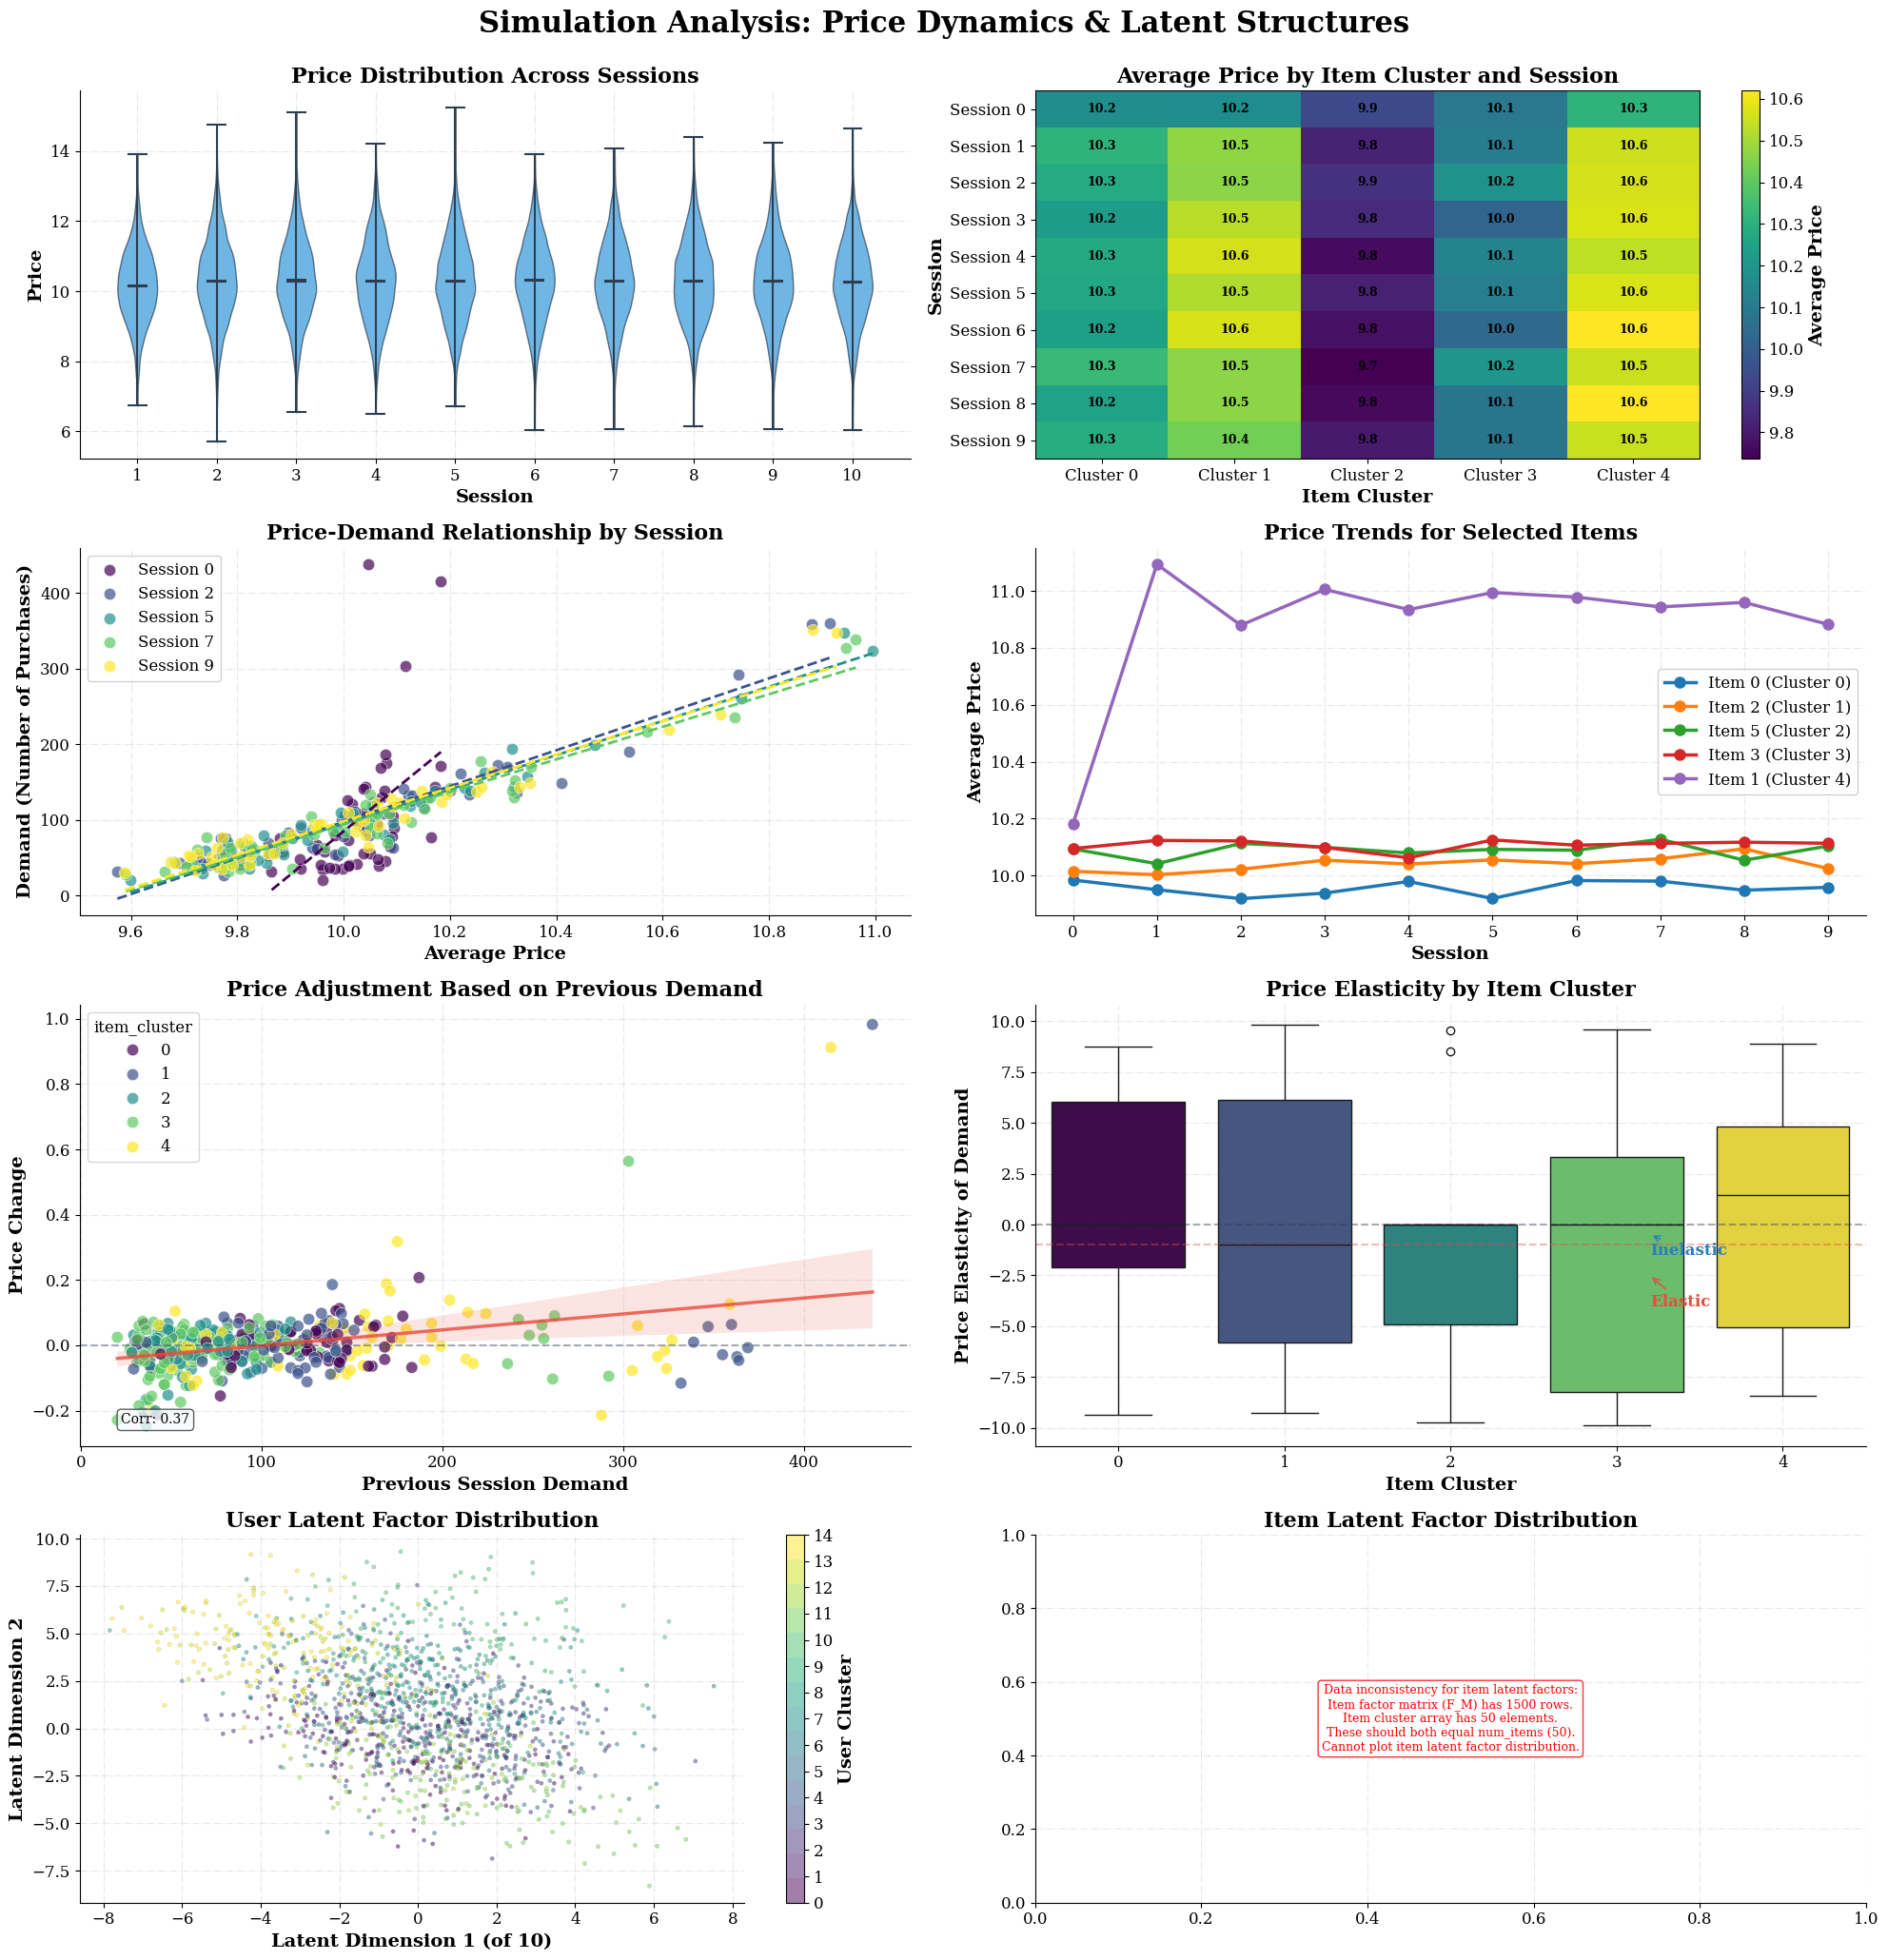

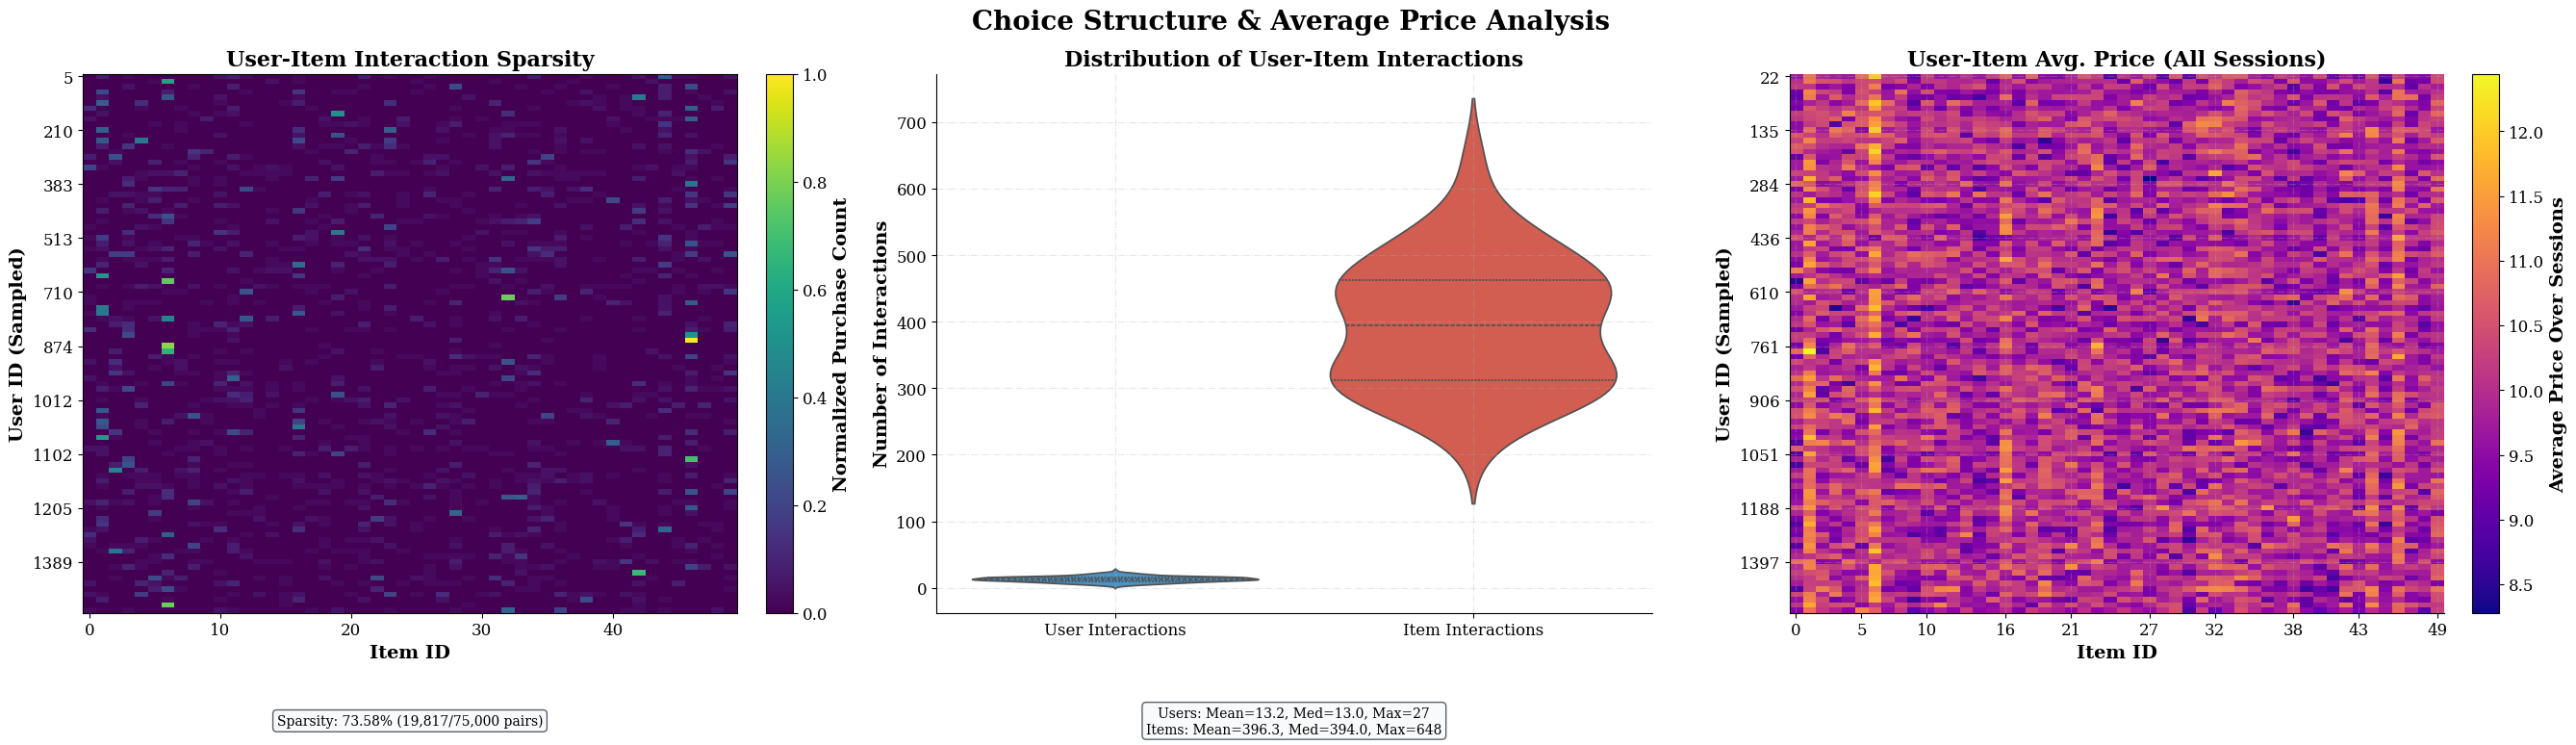

In [10]:
num_users = 1_500   # 1500 users in the dataset.
num_items = 50      # 50 items to choose from.
num_sessions = 10   # 20 different shopping occasions
data_size = 50_000  # 50,000 purchase records.

# Clustering parameters (updated)
K_u = 15       # number of user clusters
K_i = 5        # number of item clusters
R = 10         # latent dimension

# Variance parameters for clusters and within-cluster noise
sigma_cluster_u = 1.0   # std dev for user cluster means
sigma_user = 1.0        # within-user-cluster noise std dev for latent factors
sigma_cluster_i = 1.0   # std dev for item cluster means
sigma_item = 1.0        # within-item-cluster noise std dev for latent factors

# Personalized offer (treatment) generation parameters
delta_0 = 10.0      # baseline offer level
delta_1 = 0.4       # scaling factor for effect of latent interaction
sigma_P = 1.0       # noise std dev for the offer
sigma_P_session = 0.0  # session-specific variation in base offer

# Demand-driven price adjustment parameters
demand_effect = 0.25    # coefficient for how much previous session demand affects price

# Fixed effects for users and items
sigma_alpha = 0.1   # user fixed effect std dev
sigma_beta = 0.1    # item fixed effect std dev

# Utility generation parameters
direct_pref_weight = 1.0  # direct weight of user-item preference match
gamma = -0.5       # price sensitivity coefficient (negative: higher price reduces utility)
sigma_U = 0.01       # noise std dev for the utility

# Set seed for reproducibility for this simulation
simulation_seed = 42

# Generate the data by calling the function

simulation_main_kwargs = dict(
    num_users=num_users,
    num_items=num_items,
    num_sessions=num_sessions,
    data_size=data_size,
    K_u=K_u,
    K_i=K_i,
    R_latent_dim=R,  # Pass global R as R_latent_dim
    sigma_cluster_u=sigma_cluster_u,
    sigma_user=sigma_user,
    sigma_cluster_i=sigma_cluster_i,
    sigma_item=sigma_item,
    delta_0=delta_0,
    delta_1=delta_1,
    sigma_P=sigma_P,
    sigma_P_session=sigma_P_session,
    demand_effect=demand_effect,
    sigma_alpha=sigma_alpha,
    sigma_beta=sigma_beta,
    direct_pref_weight=direct_pref_weight,
    gamma=gamma,
    sigma_U=sigma_U,
    seed=simulation_seed,
)

simulation_results = generate_simulation_data(
    **simulation_main_kwargs,
    price_user_specific=True,
    price_dynamic_session=True
)

visualize_simulation_results(simulation_results)

In [11]:
# Display simulation results and analyze price variance and covariance with M
print("Simulation Results:")
print(simulation_results)

# Extract the dataframe for analysis
df = simulation_results["df_purchases"]

print("\n" + "="*60)
print("PRICE AND PREFERENCE ANALYSIS")
print("="*60)

# Calculate variance of price
price_var = df['P_uis'].var()
print(f"Variance of price (P_uis): {price_var:.6f}")

# Calculate variance of M (user-item preference match)
M_var = df['M_ui'].var()
print(f"Variance of M_ui: {M_var:.6f}")

# Calculate covariance between price and M
price_M_cov = df[['P_uis', 'M_ui']].cov()
print(f"\nCovariance matrix of P_uis and M_ui:")
print(price_M_cov)

# Calculate correlation between price and M
price_M_corr = df[['P_uis', 'M_ui']].corr()
print(f"\nCorrelation matrix of P_uis and M_ui:")
print(price_M_corr)

# Specific covariance value
cov_price_M = price_M_cov.loc['P_uis', 'M_ui']
print(f"\nCovariance between P_uis and M_ui: {cov_price_M:.6f}")
print(f"Correlation between P_uis and M_ui: {price_M_corr.loc['P_uis', 'M_ui']:.6f}")

Simulation Results:
{'df_purchases':        session  user  item  user_cluster  item_cluster      M_ui    f_M_ui  \
0            8   500    23             1             4  1.668195  0.981402   
1            1   298     1            10             4  6.627514  2.031762   
2            9   918    35             1             2  1.615806  0.961572   
3            9   635    18             9             3  2.369369  1.214726   
4            2   820    20             0             4  0.895050  0.639245   
...        ...   ...   ...           ...           ...       ...       ...   
49995        7  1423    49            12             1  3.221082  1.440092   
49996        3  1119    25             4             2  0.566810  0.449042   
49997        4  1281     1             7             4  3.698139  1.547167   
49998        8   189     6             9             1  2.424992  1.231099   
49999        0   284    21             6             4  1.421273  0.884293   

           P_uis     U_uis

In [12]:
# Regress U_uis on P_uis using y = a*x + b
import numpy as np
from sklearn.linear_model import LinearRegression

df = simulation_results["df_purchases"]
X = df['P_uis'].values.reshape(-1, 1)  # reshape for sklearn
y = df['U_uis'].values

print(df[["P_uis", "M_ui"]].cov() / df["P_uis"].var())

# Fit linear regression with both f_M_ui and P_uis as predictors using statsmodels
import statsmodels.api as sm

# Prepare data for multiple regression
X_multi = df[['M_ui', 'P_uis']]
X_multi = sm.add_constant(X_multi)  # add intercept term
y = df['U_uis']

# Fit multiple regression model
model_multi = sm.OLS(y, X_multi).fit()
print("Multiple regression: U_uis ~ M_ui + P_uis")
print(model_multi.summary())

# Also fit simple regressions for comparison
# print("\n" + "="*60)
# print("Simple regression: U_uis ~ f_M_ui")
# X_f_M_ui = sm.add_constant(df['f_M_ui'])
# model_f_M_ui = sm.OLS(y, X_f_M_ui).fit()
# print(model_f_M_ui.summary())

print("\n" + "="*60)
print("Simple regression: U_uis ~ P_uis")
X_P_uis = sm.add_constant(df['P_uis'])
model_P_uis = sm.OLS(y, X_P_uis).fit()
print(model_P_uis.summary())

# Display the dataframe as well
# df

          P_uis      M_ui
P_uis  1.000000  0.904016
M_ui   0.904016  4.223600
Multiple regression: U_uis ~ M_ui + P_uis
                            OLS Regression Results                            
Dep. Variable:                  U_uis   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 4.787e+05
Date:                Wed, 28 May 2025   Prob (F-statistic):               0.00
Time:                        12:03:34   Log-Likelihood:                -35262.
No. Observations:               50000   AIC:                         7.053e+04
Df Residuals:                   49997   BIC:                         7.056e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [13]:
%%capture --no-stderr

# Ignore UserWarning about y_pred values not summing to one
import warnings
from collections import OrderedDict
from pytorch_lightning.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=PossibleUserWarning)


# create simulation dataset.

simulation_dataset = OrderedDict([
    ("const_price", generate_simulation_data(**simulation_main_kwargs, price_user_specific=False, price_dynamic_session=False)["dataset_list"]),
    ("price_dynamic_session", generate_simulation_data(**simulation_main_kwargs, price_user_specific=False, price_dynamic_session=True)["dataset_list"]),
    ("price_user_specific", generate_simulation_data(**simulation_main_kwargs, price_user_specific=True, price_dynamic_session=False)["dataset_list"]),
    ("price_dynamic_session_user_specific", generate_simulation_data(**simulation_main_kwargs, price_user_specific=True, price_dynamic_session=True)["dataset_list"]),
])


MAX_EPOCHS = 500
records = []

ground_truth_gamma = __import__('copy').deepcopy(gamma)

utility_formula_list =  [
    # ('beta_item + gamma_constant * usersessionitem_price', None),
    ('zeta_constant + gamma_constant * usersessionitem_price', None),
    ('alpha_user + beta_item + gamma_constant * usersessionitem_price', None),
    # ('alpha_user + beta_item + gamma_constant * usersessionitem_price', None),
    ('alpha_user + beta_item + eta_user * delta_item + gamma_constant * usersessionitem_price', 10),
    ('zeta_constant + eta_user * delta_item + gamma_constant * usersessionitem_price', 10),
    # ('zeta_constant + eta_user * delta_item + gamma_constant * usersessionitem_price', 20),
    # ('eta_user * delta_item + gamma_constant * usersessionitem_price', 100),
    # ('zeta_constant * useritem_M + gamma_constant * usersessionitem_price', 5),
]

num_monte_carlo_samples = 3

for mc_smaple_idx in tqdm(range(num_monte_carlo_samples)):
    # Set random seed for reproducible training
    torch.manual_seed(42 + mc_smaple_idx)
    np.random.seed(42 + mc_smaple_idx)

    for dataset_name, dataset_list in simulation_dataset.items():  # Loop over different datasets
        for utility_formula, latent_dim in utility_formula_list:
            bemb = LitBEMBFlex(
                model_optimizer="Adam",
                learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
                pred_item=True,  # let the model predict item_index, don't change this one.
                num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
                prior_variance={"default": 1E3},
                # prior_mean={"gamma_constant": 0, "default": 0},
                utility_formula=utility_formula,
                num_users=num_users, # Global num_users from simulation setup
                num_items=num_items, # Global num_items from simulation setup
                num_sessions=num_sessions, # Global num_sessions from simulation setup
                trace_log_q=True,
                # whether to turn on obs2prior for each parameter.
                obs2prior_dict={'zeta_constant': False, 'alpha_user': False, 'alpha_constant': False,'beta_item': False, 'eta_user': False, 'delta_item': False, 'gamma_constant': False},
                # the dimension of beta_item, which is 1.
                coef_dim_dict={'zeta_constant': 1, 'alpha_user': 1, 'alpha_constant': 1, 'beta_item': 1, 'eta_user': latent_dim, 'delta_item': latent_dim, 'gamma_constant': 1},
            )


            # use GPU if available.
            bemb = bemb.to(DEVICE)

            watch_list = [
                'coef_dict.gamma_constant.variational_mean_flexible',  # Watch all lambda_item parameters
            ]
            emb, stats = bemb.fit_model(
                dataset_list, # Use current dataset_list
                batch_size=-1, # Use calculated batch_size
                num_epochs=MAX_EPOCHS,
                num_workers=0,
                early_stopping_patience=1E10, # As per original selection
                device=DEVICE,
                enable_progress_bar=False, # As per original selection
                visualize_learning_curves=False, # As per original selection,
                verbose=False, # suppress training output.
                # parameter-based early stopping.
                param_early_stopping=False,
                param_min_delta=1e-6,
                param_patience=10,
                param_mode="absolute",
                param_divergence_threshold=None,  # Stop if parameters change too much
            )

            original_tensor = bemb.model.coef_dict.gamma_constant.variational_mean
            deep_copied_tensor = __import__('copy').deepcopy(original_tensor)
            cloned_tensor = deep_copied_tensor.clone()
            est_gamma = float(cloned_tensor)

            # Clear CUDA cache to prevent memory issues
            # del bemb
            torch.cuda.empty_cache()

            records.append({
                'dataset_name': dataset_name,
                'utility_formula': utility_formula,
                'latent_dim': latent_dim,
                'actual_gamma': ground_truth_gamma,
                'est_gamma': est_gamma,
                'stats': stats, # Original stats from fit_model,
                'monte_carlo_sample_idx': mc_smaple_idx,
            })


df_mc_results = pd.DataFrame(records)

  0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=500` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using:

In [14]:
df_mc_results.to_csv("df_mc_results_v15.csv", index=False)

In [15]:
# user_fe = dataset_list[0].user_matrix.cpu().numpy().squeeze()
# item_fe = dataset_list[0].item_matrix.cpu().numpy().squeeze()

# user_fe_hat = bemb.model.coef_dict['alpha_user'].variational_mean.detach().cpu().numpy().squeeze()
# item_fe_hat = bemb.model.coef_dict['beta_item'].variational_mean.detach().cpu().numpy().squeeze()

# # Compare actual vs estimated user fixed effects
# print("User Fixed Effects Comparison:")
# print(f"Actual user FE shape: {user_fe.shape}")
# print(f"Estimated user FE shape: {user_fe_hat.shape}")
# print(f"User FE correlation: {np.corrcoef(user_fe, user_fe_hat)[0,1]:.4f}")
# print(f"User FE RMSE: {np.sqrt(np.mean((user_fe - user_fe_hat)**2)):.4f}")

# # Compare actual vs estimated item fixed effects
# print("\nItem Fixed Effects Comparison:")
# print(f"Actual item FE shape: {item_fe.shape}")
# print(f"Estimated item FE shape: {item_fe_hat.shape}")
# print(f"Item FE correlation: {np.corrcoef(item_fe, item_fe_hat)[0,1]:.4f}")
# print(f"Item FE RMSE: {np.sqrt(np.mean((item_fe - item_fe_hat)**2)):.4f}")

# # Create plots to visualize the comparison
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Plot user fixed effects comparison
# axes[0].scatter(user_fe, user_fe_hat, alpha=0.6)
# axes[0].plot([user_fe.min(), user_fe.max()], [user_fe.min(), user_fe.max()], 'r--', lw=2)
# axes[0].set_xlabel('Actual User Fixed Effects')
# axes[0].set_ylabel('Estimated User Fixed Effects')
# axes[0].set_title(f'User FE: Correlation = {np.corrcoef(user_fe, user_fe_hat)[0,1]:.4f}')
# axes[0].grid(True, alpha=0.3)

# # Plot item fixed effects comparison
# axes[1].scatter(item_fe, item_fe_hat, alpha=0.6)
# axes[1].plot([item_fe.min(), item_fe.max()], [item_fe.min(), item_fe.max()], 'r--', lw=2)
# axes[1].set_xlabel('Actual Item Fixed Effects')
# axes[1].set_ylabel('Estimated Item Fixed Effects')
# axes[1].set_title(f'Item FE: Correlation = {np.corrcoef(item_fe, item_fe_hat)[0,1]:.4f}')
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

actual_interaction variance 5.0
estimated_interaction variance 4.297811
actual_interaction norm 613.66705
estimated_interaction norm 570.4627
Interaction Matrix Comparison Metrics:
Correlation: 0.8360
RMSE: 1.2917
MAE: 1.0048
MAPE: 524.66%
Estimated magnitude (Frobenius norm): 570.4627
Actual magnitude (Frobenius norm): 613.6671
Magnitude ratio (est/actual): 0.9296


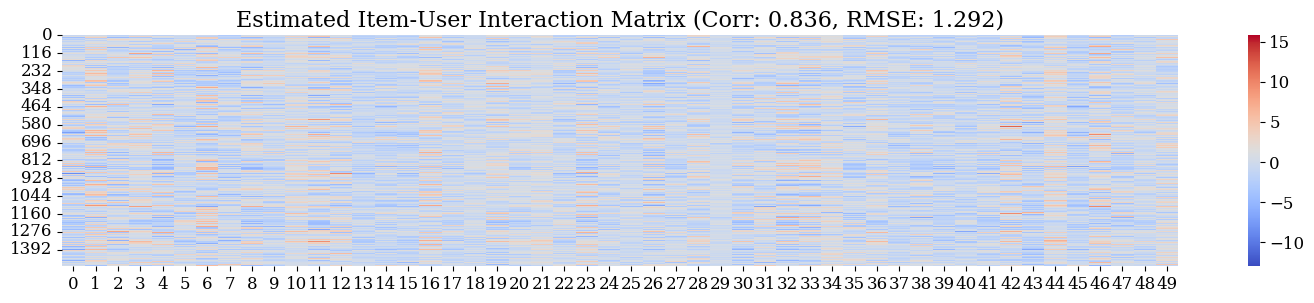

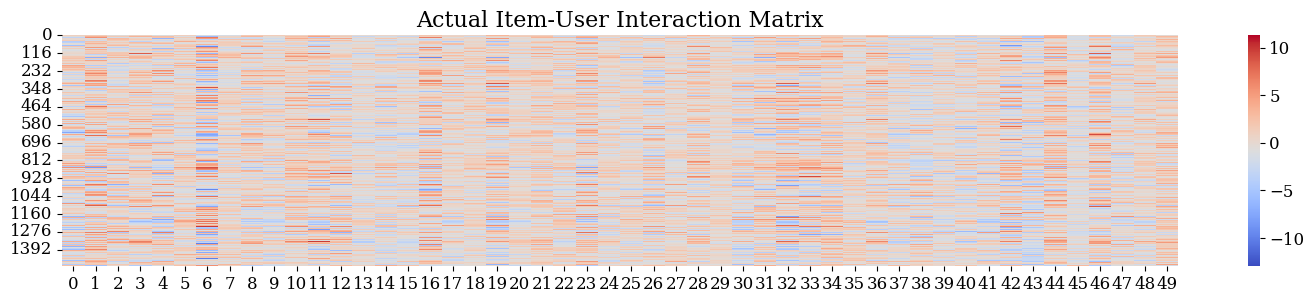

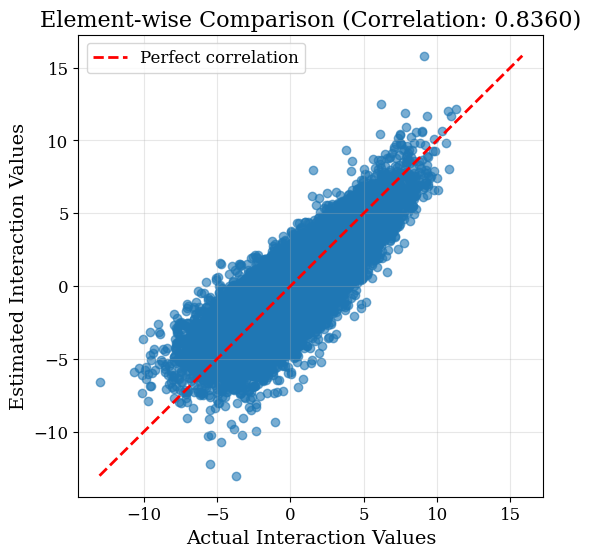

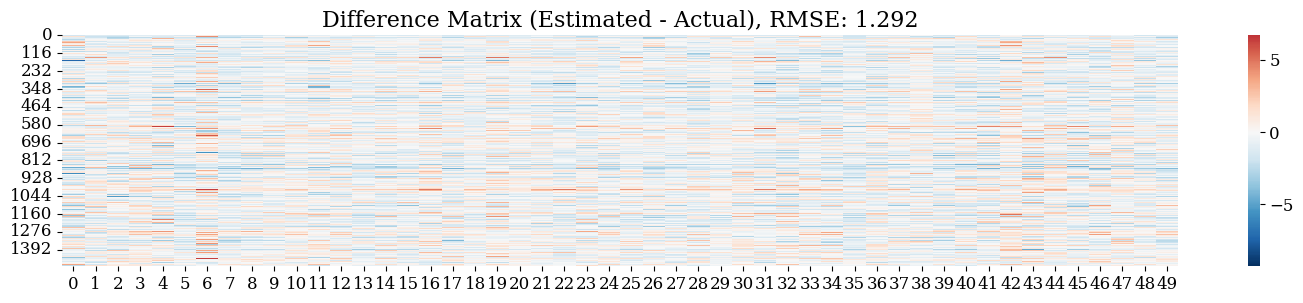

In [15]:
# visualize the prediction and compute metrics
T = bemb.model.coef_dict['eta_user'].variational_mean_flexible.data
A = bemb.model.coef_dict['delta_item'].variational_mean_flexible.data
estimated_interaction = (A @ T.T).numpy().T
actual_interaction = dataset_list[0].useritem_M.cpu().numpy().squeeze()

print("actual_interaction variance", np.var(actual_interaction.reshape(-1, 1)))
print("estimated_interaction variance", np.var(estimated_interaction.reshape(-1, 1)))
print("actual_interaction norm", np.linalg.norm(actual_interaction))
print("estimated_interaction norm", np.linalg.norm(estimated_interaction))

# Compute metrics for interaction matrix comparison
correlation = np.corrcoef(estimated_interaction.flatten(), actual_interaction.flatten())[0, 1]
rmse = np.sqrt(np.mean((estimated_interaction - actual_interaction)**2))
mae = np.mean(np.abs(estimated_interaction - actual_interaction))
mape = np.mean(np.abs((estimated_interaction - actual_interaction) / (actual_interaction + 1e-8))) * 100

# Magnitude comparison
est_magnitude = np.linalg.norm(estimated_interaction, 'fro')
actual_magnitude = np.linalg.norm(actual_interaction, 'fro')
magnitude_ratio = est_magnitude / actual_magnitude

print("Interaction Matrix Comparison Metrics:")
print(f"Correlation: {correlation:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Estimated magnitude (Frobenius norm): {est_magnitude:.4f}")
print(f"Actual magnitude (Frobenius norm): {actual_magnitude:.4f}")
print(f"Magnitude ratio (est/actual): {magnitude_ratio:.4f}")

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(estimated_interaction, square=False, ax=ax, cmap='coolwarm')
ax.set_title(f'Estimated Item-User Interaction Matrix (Corr: {correlation:.3f}, RMSE: {rmse:.3f})')
plt.show()

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(actual_interaction, square=False, ax=ax, cmap='coolwarm')
ax.set_title('Actual Item-User Interaction Matrix')
plt.show()

# Scatter plot to visualize element-wise comparison
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(actual_interaction.flatten(), estimated_interaction.flatten(), alpha=0.6)
min_val = min(actual_interaction.min(), estimated_interaction.min())
max_val = max(actual_interaction.max(), estimated_interaction.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect correlation')
ax.set_xlabel('Actual Interaction Values')
ax.set_ylabel('Estimated Interaction Values')
ax.set_title(f'Element-wise Comparison (Correlation: {correlation:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Difference heatmap
fig, ax = plt.subplots(figsize=(18, 3))
difference = estimated_interaction - actual_interaction
sns.heatmap(difference, square=False, ax=ax, cmap='RdBu_r', center=0)
ax.set_title(f'Difference Matrix (Estimated - Actual), RMSE: {rmse:.3f}')
plt.show()

In [16]:
df_mc_results = df_mc_results.sort_values(["dataset_name", "utility_formula", "latent_dim"]).reset_index(drop=True)

In [17]:
df_mc_results.head()

,dataset_name,utility_formula,latent_dim,actual_gamma,est_gamma,stats,monte_carlo_sample_idx
0,const_price,alpha_user + beta_item + eta_user * delta_item...,10.0,-0.5,-0.725461,"{'train_elbo': [823753.875, 793162.75, 772650....",0
1,const_price,alpha_user + beta_item + eta_user * delta_item...,10.0,-0.5,-0.378671,"{'train_elbo': [831872.375, 810705.625, 803426...",1
2,const_price,alpha_user + beta_item + eta_user * delta_item...,10.0,-0.5,-0.482240,"{'train_elbo': [818314.375, 813116.25, 783234....",2
3,const_price,alpha_user + beta_item + gamma_constant * user...,NaN,-0.5,-0.699973,"{'train_elbo': [240595.890625, 239612.40625, 2...",0
4,const_price,alpha_user + beta_item + gamma_constant * user...,NaN,-0.5,-0.332725,"{'train_elbo': [264695.75, 238883.078125, 2374...",1


In [22]:
# df_mc_results["specification"] = df_mc_results["utility_formula"] + " (dim=" + df_mc_results["latent_dim"].astype(str) + ")"
# g = sns.FacetGrid(df_mc_results, col="dataset_name", col_wrap=2, height=4, aspect=1.2)
# g.map_dataframe(sns.boxenplot, x="specification", y="est_gamma")
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', rotation=45)
#     for label in ax.get_xticklabels():
#         label.set_ha('right')
#     # Add horizontal line for ground truth
#     ax.axhline(y=-0.5, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Ground Truth (γ = -0.5)')
#     ax.axhline(y=0.0, color='blue', linestyle='-.', linewidth=2, alpha=0.8, label='Reference (γ = 0.0)')
# g.set_ylabels("Estimated γ (Price Coefficient)")
# g.set_xlabels("Model Specification")
# # Add legend to the first subplot
# g.axes.flat[0].legend()
# plt.tight_layout()
# plt.show()

dataset_name,utility_formula,latent_dim,est_gamma,actual_gamma,avg_test_ll,rmse_gamma
const_price,zeta_constant + gamma_constant * usersessionitem_price,N/A,-0.4467,-0.5,-3.8098,0.0541
const_price,alpha_user + beta_item + gamma_constant * usersessionitem_price,N/A,-0.3434,-0.5,-3.4989,0.3268
const_price,alpha_user + beta_item + eta_user * delta_item + gamma_constant * usersessionitem_price,10.0,-0.5288,-0.5,-2.4676,0.1482
const_price,zeta_constant + eta_user * delta_item + gamma_constant * usersessionitem_price,10.0,-0.5148,-0.5,-2.4718,0.0159
price_dynamic_session,zeta_constant + gamma_constant * usersessionitem_price,N/A,-0.2756,-0.5,-3.8714,0.2244
price_dynamic_session,alpha_user + beta_item + gamma_constant * usersessionitem_price,N/A,-0.4147,-0.5,-3.5938,0.0853
price_dynamic_session,alpha_user + beta_item + eta_user * delta_item + gamma_constant * usersessionitem_price,10.0,-0.5182,-0.5,-2.5801,0.0187
price_dynamic_session,zeta_constant + eta_user * delta_item + gamma_constant * usersessionitem_price,10.0,-0.5124,-0.5,-2.5753,0.0146
price_user_specific,zeta_constant + gamma_constant * usersessionitem_price,N/A,0.1081,-0.5,-3.9051,0.6081
price_user_specific,alpha_user + beta_item + gamma_constant * usersessionitem_price,N/A,0.0713,-0.5,-3.6428,0.5714


Number of datasets: 4
Datasets: ['const_price', 'price_dynamic_session', 'price_user_specific', 'price_dynamic_session_user_specific']
Number of model combinations: 4
Model combinations: ['zeta_constant + gamma_constant * usersessionitem_price', 'alpha_user + beta_item + gamma_constant * usersessionitem_price', 'alpha_user + beta_item + eta_user * delta_item + gamma_constant * usersessionitem_price (dim=10.0)', 'zeta_constant + eta_user * delta_item + gamma_constant * usersessionitem_price (dim=10.0)']


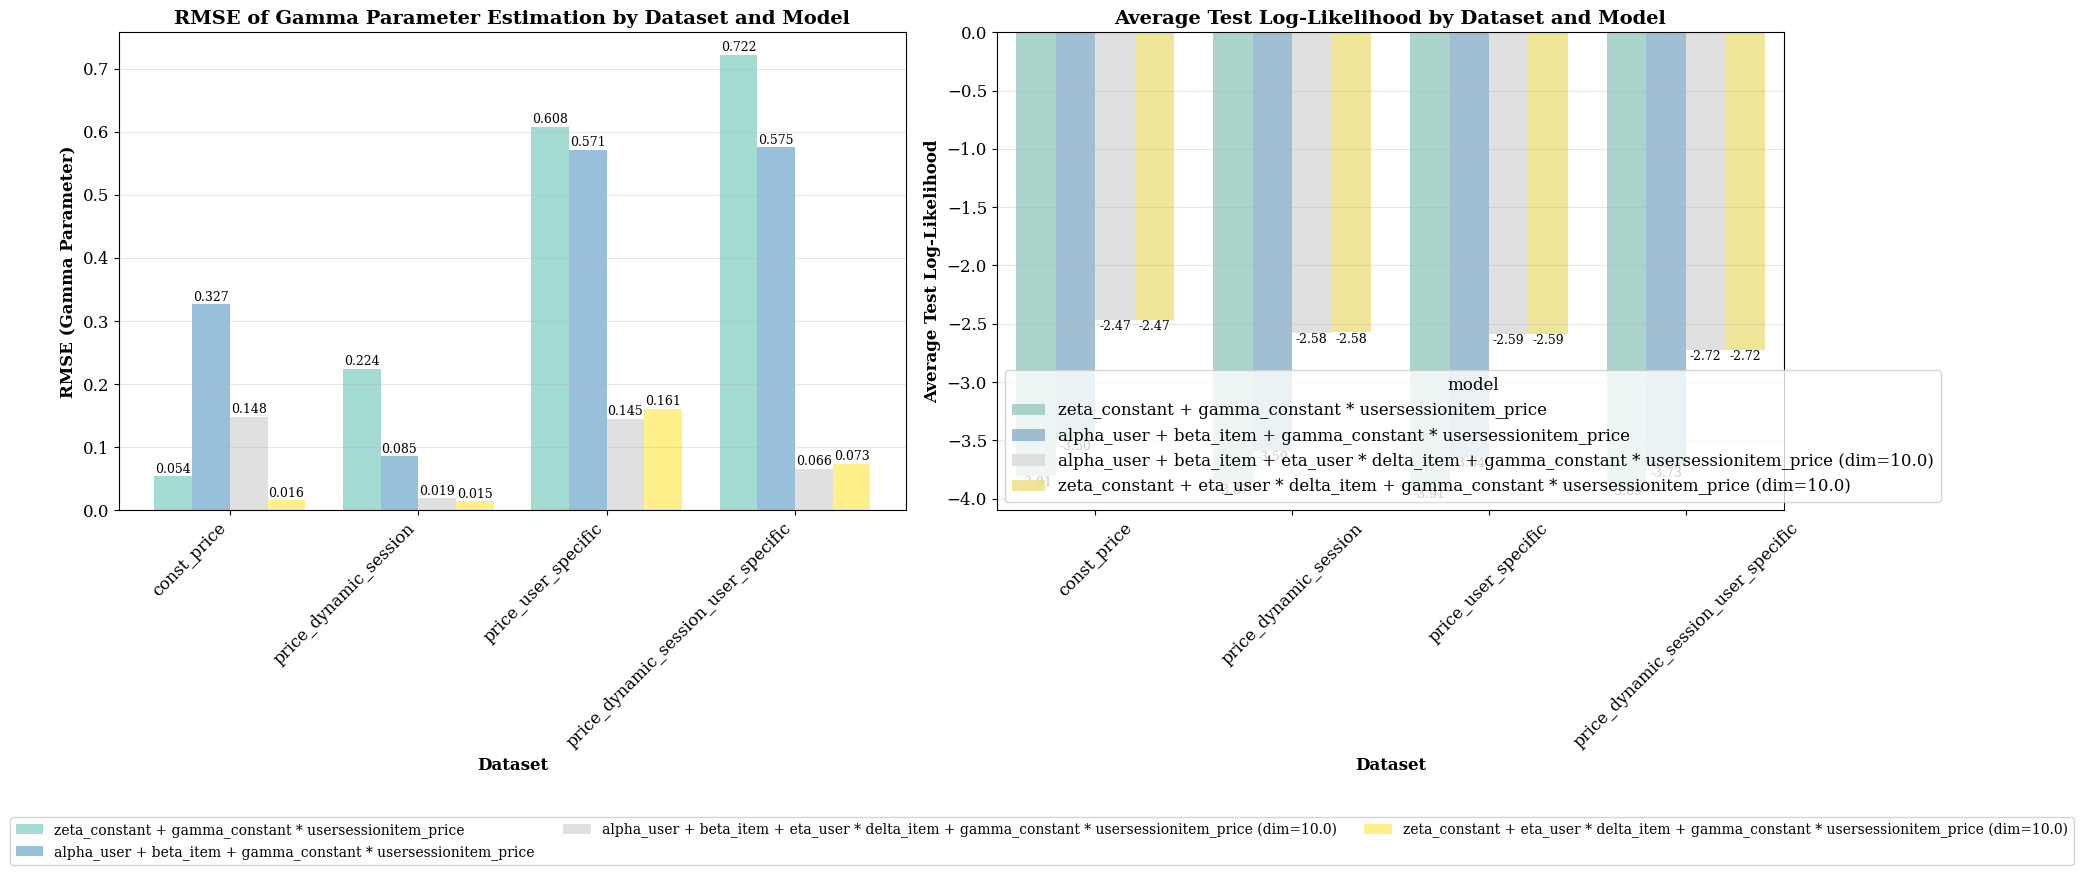


Distribution plot data check:
Unique datasets: []
Unique model labels: []
Number of rows per dataset-model combination:
Series([], dtype: int64)
No gamma models found for distribution plots


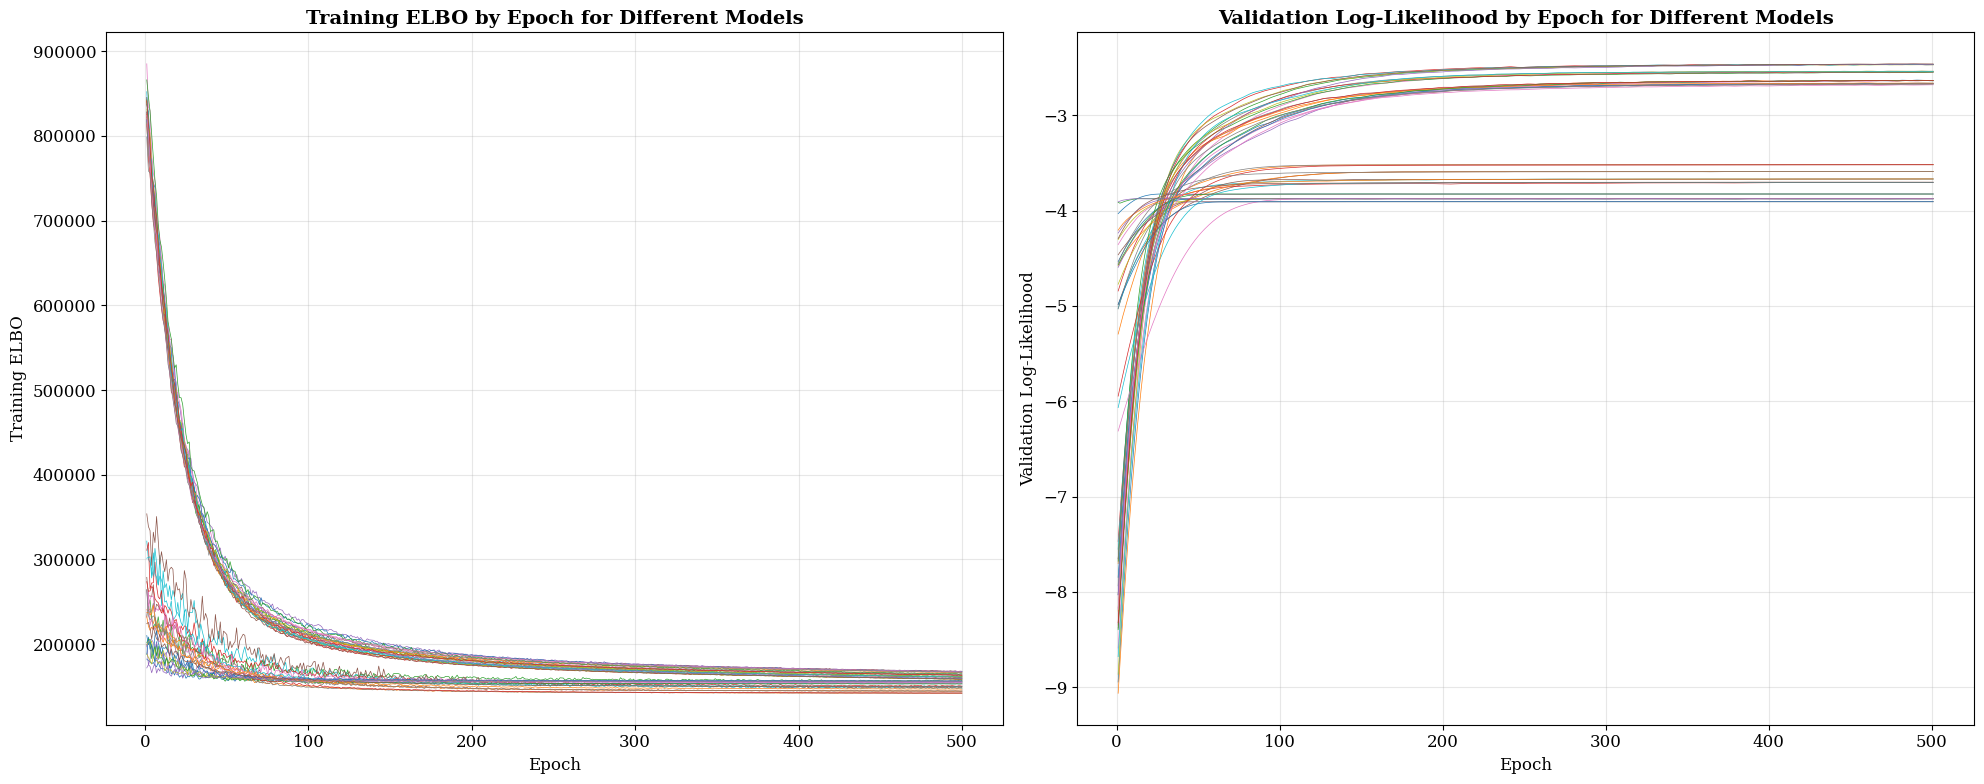

In [23]:
# Create a summary table with average est_gamma and test_ll by dataset_name, utility_formula, and latent_dim
df_mc_results["latent_dim"] = df_mc_results["latent_dim"].fillna("N/A")

# First, let's extract test_ll values properly
def extract_test_ll(stats_series):
    test_ll_values = []
    for stats in stats_series:
        if isinstance(stats, dict) and 'test_ll' in stats:
            test_ll_values.append(stats['test_ll'].item() if hasattr(stats['test_ll'], 'item') else stats['test_ll'])
    return np.mean(test_ll_values) if test_ll_values else np.nan

summary_table = df_mc_results.groupby(['dataset_name', 'utility_formula', 'latent_dim']).agg({
    'est_gamma': 'mean',
    'actual_gamma': 'first',  # Just get the first value since it's the same for all rows in a group
    'stats': extract_test_ll
}).rename(columns={'stats': 'avg_test_ll'}).reset_index()

# Calculate RMSE for gamma after groupby
rmse_values = df_mc_results.groupby(['dataset_name', 'utility_formula', 'latent_dim']).apply(
    lambda group: np.sqrt(np.mean((group['est_gamma'] - group['actual_gamma'])**2)),
    include_groups=False
).reset_index(name='rmse_gamma')

# Merge the RMSE values with the summary table
summary_table = summary_table.merge(rmse_values, on=['dataset_name', 'utility_formula', 'latent_dim'], how='left', validate='one_to_one')

# Sort dataset_name by simulation_dataset.keys() and utility_formula by utility_formula_list
dataset_order = list(simulation_dataset.keys())
summary_table['dataset_name'] = pd.Categorical(summary_table['dataset_name'], categories=dataset_order, ordered=True)

# Extract just the formulas from utility_formula_list for ordering
formula_order = [formula for formula, _ in utility_formula_list]
# Remove duplicates while preserving order
formula_order = list(dict.fromkeys(formula_order))
summary_table['utility_formula'] = pd.Categorical(summary_table['utility_formula'], categories=formula_order, ordered=True)
summary_table = summary_table.sort_values(['dataset_name', 'utility_formula'])

# Create HTML presentation of the summary table
from IPython.display import HTML

# Format numeric columns for better presentation
summary_table_display = summary_table.copy()
summary_table_display['est_gamma'] = summary_table_display['est_gamma'].round(4)
summary_table_display['actual_gamma'] = summary_table_display['actual_gamma'].round(4)
summary_table_display['avg_test_ll'] = summary_table_display['avg_test_ll'].round(4)
summary_table_display['rmse_gamma'] = summary_table_display['rmse_gamma'].round(4)

# Convert to HTML with styling
html_table = summary_table_display.to_html(
    index=False,
    classes='table table-striped table-bordered',
    table_id='summary-table',
    escape=False
)

# Add custom CSS styling optimized for dark themes
styled_html = f"""
<style>
#summary-table {{
    margin: 20px auto;
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    font-size: 14px;
    max-width: 100%;
    background-color: var(--jp-layout-color1, #ffffff);
    color: var(--jp-content-font-color1, #333333);
}}

#summary-table th {{
    background-color: var(--jp-layout-color2, #f8f9fa);
    color: var(--jp-content-font-color1, #333333);
    font-weight: bold;
    padding: 12px 8px;
    text-align: center;
    border: 1px solid var(--jp-border-color1, #dee2e6);
}}

#summary-table td {{
    padding: 10px 8px;
    text-align: center;
    border: 1px solid var(--jp-border-color1, #dee2e6);
    background-color: var(--jp-layout-color1, #ffffff);
}}

#summary-table tr:nth-child(even) td {{
    background-color: var(--jp-layout-color2, #f8f9fa);
}}

#summary-table tr:hover td {{
    background-color: var(--jp-layout-color3, #e9ecef);
}}

.table-title {{
    text-align: center;
    font-size: 18px;
    font-weight: bold;
    margin-bottom: 15px;
    color: var(--jp-content-font-color1, #333333);
}}

/* Dark theme specific overrides */
@media (prefers-color-scheme: dark) {{
    #summary-table {{
        background-color: #2d2d2d;
        color: #e0e0e0;
    }}

    #summary-table th {{
        background-color: #404040;
        color: #e0e0e0;
        border: 1px solid #555555;
    }}

    #summary-table td {{
        background-color: #2d2d2d;
        border: 1px solid #555555;
    }}

    #summary-table tr:nth-child(even) td {{
        background-color: #353535;
    }}

    #summary-table tr:hover td {{
        background-color: #454545;
    }}

    .table-title {{
        color: #e0e0e0;
    }}
}}

/* JupyterLab dark theme detection */
.jp-RenderedHTMLCommon[data-jp-theme-light="false"] #summary-table {{
    background-color: #2d2d2d;
    color: #e0e0e0;
}}

.jp-RenderedHTMLCommon[data-jp-theme-light="false"] #summary-table th {{
    background-color: #404040;
    color: #e0e0e0;
    border: 1px solid #555555;
}}

.jp-RenderedHTMLCommon[data-jp-theme-light="false"] #summary-table td {{
    background-color: #2d2d2d;
    border: 1px solid #555555;
}}

.jp-RenderedHTMLCommon[data-jp-theme-light="false"] #summary-table tr:nth-child(even) td {{
    background-color: #353535;
}}

.jp-RenderedHTMLCommon[data-jp-theme-light="false"] #summary-table tr:hover td {{
    background-color: #454545;
}}

.jp-RenderedHTMLCommon[data-jp-theme-light="false"] .table-title {{
    color: #e0e0e0;
}}
</style>

<div class="table-title">Monte Carlo Simulation Results Summary</div>
{html_table}
"""

display(HTML(styled_html))

# Create a combined label for utility_formula and latent_dim
summary_table['model_label'] = summary_table.apply(
    lambda row: f"{row['utility_formula']}" + (f" (dim={row['latent_dim']})" if row['latent_dim'] != "N/A" else ""),
    axis=1
)

# Get unique datasets and model combinations
datasets = summary_table['dataset_name'].unique()
model_combinations = summary_table['model_label'].unique()

print(f"Number of datasets: {len(datasets)}")
print(f"Datasets: {list(datasets)}")
print(f"Number of model combinations: {len(model_combinations)}")
print(f"Model combinations: {list(model_combinations)}")

# Create color palette that will be consistent across both plots
colors = plt.cm.Set3(np.linspace(0, 1, len(model_combinations)))
color_map = {model: colors[i] for i, model in enumerate(model_combinations)}

# Create side-by-side plots for RMSE and average test log-likelihood
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Set up bar positions
x = np.arange(len(datasets))
width = 0.8 / len(model_combinations)  # Width of bars

# Plot RMSE bars (left subplot)
for i, model in enumerate(model_combinations):
    model_data = summary_table[summary_table['model_label'] == model]

    # Get RMSE values for each dataset (fill with 0 if missing)
    rmse_values = []
    for dataset in datasets:
        dataset_rmse = model_data[model_data['dataset_name'] == dataset]['rmse_gamma']
        if len(dataset_rmse) > 0:
            rmse_values.append(dataset_rmse.iloc[0])
        else:
            rmse_values.append(0)

    # Plot bars with consistent colors
    bars = ax1.bar(x + i * width, rmse_values, width, label=model, color=color_map[model], alpha=0.8)

    # Add value labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:  # Only add label if there's a value
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, rotation=0)

# Customize the RMSE plot
ax1.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (Gamma Parameter)', fontsize=12, fontweight='bold')
ax1.set_title('RMSE of Gamma Parameter Estimation by Dataset and Model', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * (len(model_combinations) - 1) / 2)
ax1.set_xticklabels(datasets, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(bottom=0)

# Plot average test log-likelihood bars (right subplot) using seaborn
# Prepare data for seaborn
plot_data = []
for model in model_combinations:
    model_data = summary_table[summary_table['model_label'] == model]
    for dataset in datasets:
        dataset_avg_test_ll = model_data[model_data['dataset_name'] == dataset]['avg_test_ll']
        if len(dataset_avg_test_ll) > 0:
            avg_test_ll = dataset_avg_test_ll.iloc[0]
        else:
            avg_test_ll = 0
        plot_data.append({
            'dataset': dataset,
            'model': model,
            'avg_test_ll': avg_test_ll
        })

plot_df = pd.DataFrame(plot_data)

# Create seaborn barplot
sns.barplot(data=plot_df, x='dataset', y='avg_test_ll', hue='model',
           palette=[color_map[model] for model in model_combinations],
           alpha=0.8, ax=ax2)

# Add value labels on top of bars
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', fontsize=9, rotation=0)

# Customize the average test log-likelihood plot
ax2.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Test Log-Likelihood', fontsize=12, fontweight='bold')
ax2.set_title('Average Test Log-Likelihood by Dataset and Model', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add legend at the bottom of the figure
fig.legend(model_combinations, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)

plt.tight_layout()
plt.show()

# Create distribution plots for estimated gamma values
# Prepare data for distribution plots
df_mc_results['model_label'] = df_mc_results.apply(
    lambda row: f"{row['utility_formula']}" + (f" (dim={row['latent_dim']})" if pd.notna(row['latent_dim']) else ""),
    axis=1
)

# Filter data to only include models with gamma parameters
gamma_models = df_mc_results[df_mc_results['utility_formula'].str.contains('gamma_user')]

# Get unique datasets and models
datasets = gamma_models['dataset_name'].unique()
models = gamma_models['model_label'].unique()

print(f"\nDistribution plot data check:")
print(f"Unique datasets: {list(datasets)}")
print(f"Unique model labels: {list(models)}")
print(f"Number of rows per dataset-model combination:")
print(gamma_models.groupby(['dataset_name', 'model_label']).size())

if len(gamma_models) > 0:
    # Create violin plot for estimated gamma values by dataset and model
    fig, ax = plt.subplots(figsize=(16, 8))

    # Create violin plot using seaborn
    sns.violinplot(data=gamma_models, x='dataset_name', y='est_gamma', hue='model_label',
                   ax=ax, palette='Set2', inner='box')

    # Add horizontal lines for actual gamma values for each dataset
    for dataset in datasets:
        dataset_data = gamma_models[gamma_models['dataset_name'] == dataset]
        if len(dataset_data) > 0:
            actual_gamma = dataset_data['actual_gamma'].iloc[0]
            # Get x position for this dataset
            dataset_idx = list(datasets).index(dataset)
            ax.axhline(y=actual_gamma, xmin=(dataset_idx-0.4)/len(datasets),
                      xmax=(dataset_idx+0.4)/len(datasets),
                      color='red', linestyle='--', linewidth=2, alpha=0.8)

    # Add a legend entry for the true gamma line
    ax.axhline(y=float('nan'), color='red', linestyle='--', linewidth=2,
               label='True γ value', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_ylabel('Estimated Gamma', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Estimated Gamma Values by Dataset and Model', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Create histogram/density plots for gamma estimates
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        if i < len(axes):
            ax = axes[i]
            dataset_data = gamma_models[gamma_models['dataset_name'] == dataset]

            # Create histogram for each model
            for model in models:
                model_data = dataset_data[dataset_data['model_label'] == model]
                if len(model_data) > 0:
                    ax.hist(model_data['est_gamma'], alpha=0.6, label=model, bins=10, density=True)

            # Add vertical line for true gamma value
            if len(dataset_data) > 0:
                actual_gamma = dataset_data['actual_gamma'].iloc[0]
                ax.axvline(x=actual_gamma, color='red', linestyle='--', linewidth=2,
                          label=f'True γ = {actual_gamma:.2f}')

            ax.set_xlabel('Estimated Gamma', fontsize=10)
            ax.set_ylabel('Density', fontsize=10)
            ax.set_title(f'Distribution of Gamma Estimates - {dataset}', fontsize=12, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(datasets), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Create box plots for gamma estimates
    fig, ax = plt.subplots(figsize=(16, 8))

    # Create box plot using seaborn
    sns.boxplot(data=gamma_models, x='dataset_name', y='est_gamma', hue='model_label',
                ax=ax, palette='Set2')

    # Add horizontal lines for actual gamma values for each dataset
    for dataset in datasets:
        dataset_data = gamma_models[gamma_models['dataset_name'] == dataset]
        if len(dataset_data) > 0:
            actual_gamma = dataset_data['actual_gamma'].iloc[0]
            # Get x position for this dataset
            dataset_idx = list(datasets).index(dataset)
            ax.axhline(y=actual_gamma, xmin=(dataset_idx-0.4)/len(datasets),
                      xmax=(dataset_idx+0.4)/len(datasets),
                      color='red', linestyle='--', linewidth=2, alpha=0.8)

    # Add a legend entry for the true gamma line
    ax.axhline(y=float('nan'), color='red', linestyle='--', linewidth=2,
               label='True γ value', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Dataset', fontsize=12, fontweight='bold')
    ax.set_ylabel('Estimated Gamma', fontsize=12, fontweight='bold')
    ax.set_title('Box Plot of Estimated Gamma Values by Dataset and Model', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

else:
    print("No gamma models found for distribution plots")

# Plot training ELBO and validation log-likelihood curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for i, record in enumerate(records):
    utility_formula = record['utility_formula']
    latent_dim = record['latent_dim']
    stats = record['stats']

    # # Create label for the model
    # if latent_dim is None:
    #     label = utility_formula.replace('_', ' ')
    # else:
    #     label = f"{utility_formula.replace('_', ' ')} (dim={latent_dim})"
    label = None

    # Plot training ELBO
    if 'train_elbo' in stats:
        train_elbo = stats["train_elbo"]
        epochs = range(1, len(train_elbo) + 1)
        ax1.plot(epochs, train_elbo, label=label, linewidth=0.5, alpha=1.0, markersize=1)

    # Plot validation log-likelihood
    if 'val_ll' in stats:
        val_ll = stats["val_ll"]
        epochs = range(1, len(val_ll) + 1)
        ax2.plot(epochs, val_ll, label=label, linewidth=0.5, alpha=1.0, markersize=1)

# Configure first subplot (training ELBO)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training ELBO', fontsize=12)
ax1.set_title('Training ELBO by Epoch for Different Models', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Configure second subplot (validation log-likelihood)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Log-Likelihood', fontsize=12)
ax2.set_title('Validation Log-Likelihood by Epoch for Different Models', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
summary_table

,dataset_name,utility_formula,latent_dim,est_gamma,actual_gamma,avg_test_ll,rmse_gamma,model_label
3,const_price,zeta_constant + gamma_constant * usersessionit...,N/A,-0.446748,-0.5,-3.809803,0.054055,zeta_constant + gamma_constant * usersessionit...
1,const_price,alpha_user + beta_item + gamma_constant * user...,N/A,-0.343447,-0.5,-3.498907,0.326768,alpha_user + beta_item + gamma_constant * user...
0,const_price,alpha_user + beta_item + eta_user * delta_item...,10.0,-0.528791,-0.5,-2.467642,0.148176,alpha_user + beta_item + eta_user * delta_item...
2,const_price,zeta_constant + eta_user * delta_item + gamma_...,10.0,-0.514804,-0.5,-2.471842,0.015903,zeta_constant + eta_user * delta_item + gamma_...
7,price_dynamic_session,zeta_constant + gamma_constant * usersessionit...,N/A,-0.275648,-0.5,-3.871401,0.224399,zeta_constant + gamma_constant * usersessionit...
5,price_dynamic_session,alpha_user + beta_item + gamma_constant * user...,N/A,-0.414734,-0.5,-3.593811,0.085315,alpha_user + beta_item + gamma_constant * user...
4,price_dynamic_session,alpha_user + beta_item + eta_user * delta_item...,10.0,-0.518220,-0.5,-2.580131,0.018714,alpha_user + beta_item + eta_user * delta_item...
6,price_dynamic_session,zeta_constant + eta_user * delta_item + gamma_...,10.0,-0.512355,-0.5,-2.575307,0.014560,zeta_constant + eta_user * delta_item + gamma_...
15,price_user_specific,zeta_constant + gamma_constant * usersessionit...,N/A,0.108057,-0.5,-3.905133,0.608087,zeta_constant + gamma_constant * usersessionit...
13,price_user_specific,alpha_user + beta_item + gamma_constant * user...,N/A,0.071316,-0.5,-3.642752,0.571404,alpha_user + beta_item + gamma_constant * user...


In [27]:
# Drop utility_formula and latent_dim columns, move model_label to second column
summary_table_display = __import__("copy").deepcopy(summary_table)
summary_table_display = summary_table_display.drop(columns=['utility_formula', 'latent_dim'])
cols = summary_table_display.columns.tolist()
if 'model_label' in cols:
    cols.remove('model_label')
    cols.insert(1, 'model_label')
    summary_table_display = summary_table_display[cols]
print(summary_table_display.to_markdown() \
    .replace("zeta_constant + gamma_constant * usersessionitem_price ", "$\\zeta + \\gamma P$") \
    .replace("alpha_user + beta_item + gamma_constant * usersessionitem_price", "$\\alpha_u + \\beta_i + \\gamma P$") \
    .replace("alpha_user + beta_item + eta_user * delta_item + gamma_constant * usersessionitem_price (dim=10.0)", "$\\alpha_u + \\beta_i + \\eta_u^\\top \\delta_i + \\gamma P$") \
    .replace("zeta_constant + eta_user * delta_item + gamma_constant * usersessionitem_price (dim=10.0)", "$\\zeta + \\eta_u^\\top \\delta_i + \\gamma P$"))

|    | dataset_name                        | model_label                                                                                        |   est_gamma |   actual_gamma |   avg_test_ll |   rmse_gamma |
|---:|:------------------------------------|:---------------------------------------------------------------------------------------------------|------------:|---------------:|--------------:|-------------:|
|  3 | const_price                         | $\zeta + \gamma P$                                            |  -0.446748  |           -0.5 |      -3.8098  |    0.0540552 |
|  1 | const_price                         | $\alpha_u + \beta_i + \gamma P$                                    |  -0.343447  |           -0.5 |      -3.49891 |    0.326768  |
|  0 | const_price                         | $\alpha_u + \beta_i + \eta_u^\top \delta_i + \gamma P$ |  -0.528791  |           -0.5 |      -2.46764 |    0.148176  |
|  2 | const_price                         | $\zeta + \eta_u^\top \delta_

In [ ]:
# Ignore UserWarning about y_pred values not summing to one
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The y_pred values do not sum to one")


MAX_EPOCHS = 500
records = []

for utility_formula, latent_dim in [
    ('alpha_user + beta_item', None),
    ('alpha_constant + beta_item', None),
    ('alpha_user + beta_item + gamma_user * delta_item', 2),
    ('alpha_user + beta_item + gamma_user * delta_item', 5),
    ('alpha_user + beta_item + gamma_user * delta_item', 10),
    ('alpha_user + beta_item + gamma_user * delta_item', 30),
]:
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO, smaller number for faster training, more samples for better gradient estimation.
        utility_formula=utility_formula,
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'alpha_user': False, 'alpha_constant': False,'beta_item': False, 'gamma_user': False, 'delta_item': False},
        # the dimension of beta_item, which is 1.
        coef_dim_dict={'alpha_user': 1, 'alpha_constant': 1, 'beta_item': 1, 'gamma_user': latent_dim, 'delta_item': latent_dim},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb, stats = bemb.fit_model(
        split_dataset_into_train_val_test(dataset_nonlinear),
        # full batch training.
        batch_size=len(dataset_nonlinear)//5, num_epochs=MAX_EPOCHS, num_workers=8, early_stopping_patience=3, device=DEVICE, enable_progress_bar=False, visualize_learning_curves=False)

    records.append((utility_formula, latent_dim, stats))

In [ ]:
records[0]

In [13]:
from typing import List, Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt
import numpy as np
import re

def format_utility_formula(formula: str) -> str:
    """
    Convert utility formula to a prettier format with Greek letters.

    Args:
        formula: A utility formula string like 'alpha_user + beta_item'

    Returns:
        A formatted string with Greek letters and proper subscripts
    """
    # Define mapping of parameter names to Greek letters with subscripts
    greek_mapping = {
        'alpha_user': r'$\alpha_{user}$',
        'alpha_constant': r'$\alpha$',
        'alpha_item': r'$\alpha_{item}$',
        'beta_user': r'$\beta_{user}$',
        'beta_item': r'$\beta_{item}$',
        'gamma_user': r'$\gamma_{user}$',
        'gamma_item': r'$\gamma_{item}$',
        'delta_user': r'$\delta_{user}$',
        'delta_item': r'$\delta_{item}$',
        'theta_user': r'$\theta_{user}$',
        'eta_item': r'$\eta_{item}$',
        'pi_user': r'$\pi_{user}$',
    }

    # Replace parameter names with their Greek equivalents
    for param, greek in greek_mapping.items():
        formula = formula.replace(param, greek)

    # Format operators
    formula = formula.replace(' * ', ' · ')

    return formula

def visualize_model_results(
    records: List[Tuple[str, Optional[int], Dict[str, Any]]]
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Visualize the training, validation, and test results from multiple model configurations.
    Shows negative log-likelihood for validation and test metrics (lower is better for all plots).

    Args:
        records: List of tuples (utility_formula, latent_dim, stats) with model results

    Returns:
        Tuple containing (figure, axes) for further customization if needed
    """
    # Create descriptive labels for each model with Greek letter formatting
    model_labels = []
    for utility_formula, latent_dim, _ in records:
        formatted_formula = format_utility_formula(utility_formula)
        if latent_dim is None:
            model_labels.append(f"{formatted_formula}")
        else:
            model_labels.append(f"{formatted_formula} (dim={latent_dim})")

    # Color map for consistent colors across plots
    colors = plt.cm.tab10(np.linspace(0, 1, len(records)))

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=300)

    # Subplot 1: Training ELBO by epochs
    for i, (_, _, stats) in enumerate(records):
        epochs = range(1, len(stats['train_elbo']) + 1)
        axes[0].plot(epochs, stats['train_elbo'], marker='o', markersize=4,
                     linewidth=0.8, color=colors[i], label=model_labels[i])

    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Training ELBO')
    axes[0].set_title('Training ELBO\n(lower is better)')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Subplot 2: Negative Validation Log-Likelihood by epochs
    for i, (_, _, stats) in enumerate(records):
        epochs = range(1, len(stats['val_ll']) + 1)
        # Negate val_ll to show negative log-likelihood
        axes[1].plot(epochs, [-ll for ll in stats['val_ll']], marker='s', markersize=4,
                     linewidth=0.8, color=colors[i], label=model_labels[i])

    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Negative Validation Log-Likelihood')
    axes[1].set_title('Negative Validation Log-Likelihood\n(lower is better)')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Subplot 3: Negative Test Log-Likelihood for each model
    # Negate test_ll to show negative log-likelihood
    test_neg_ll_values = [-stats['test_ll'].item() for _, _, stats in records]

    bars = axes[2].bar(range(len(model_labels)), test_neg_ll_values, color=colors, width=0.7)

    # Add value labels on top of bars
    for bar, val in zip(bars, test_neg_ll_values):
        height = bar.get_height()
        axes[2].annotate(f'{val:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0)

    axes[2].set_xlabel('Model Configuration')
    axes[2].set_ylabel('Negative Test Log-Likelihood')
    axes[2].set_title('Negative Test Log-Likelihood\n(lower is better)')
    axes[2].set_xticks(range(len(model_labels)))
    axes[2].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[2].grid(True, linestyle='--', alpha=0.7, axis='y')

    # Add a vertically stacked legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',  # Position at the center
               bbox_to_anchor=(0.5, 0.30),  # Position below the plots
               ncol=1,  # Stack items vertically (one column)
               fancybox=True,
               shadow=True,
               frameon=True)

    plt.tight_layout()
    # Adjust bottom margin to make room for the vertically stacked legend
    plt.subplots_adjust(bottom=0.20 + 0.03*len(records))  # Scale based on number of items

    return fig, axes

In [ ]:
visualize_model_results(records=records)

# [[[JUMP HERE]]]

# Previous Simulation Studies.

In [7]:
# we assign random users and sessions to each choice record.
user_index = torch.LongTensor(np.random.choice(num_users, size=data_size))
session_index = torch.LongTensor(np.random.choice(num_sessions, size=data_size))

In [8]:
# a helper function to plot distributions of entries in a tensor.
def plot_tensor(tensor):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=DPI)
    sns.histplot(tensor.view(-1,).numpy(), bins=40, ax=ax)
    fig.show()

# Simulation Study 1: Item-Level "Random" Effect on User Attributes

## Simulate Dataset
We first specify the number of users and number of items in the dataset.
The `data_size` denotes the number of user-item choice pairs to generate (i.e., number of observations.)
Each user-item choice pair is called a **purchasing record** in our terminology, you can revise the data management tutorial.

In [ ]:
# generate random user income data.
user_income = (torch.randn(num_users) + 5).clamp(min=0)
# plot the histogram of user income.
plot_tensor(user_income)

In [ ]:
# generate item price data.
item_price = torch.rand(num_items) * 50 + 50
# plot distribution of item prices.
plot_tensor(item_price)
# WLOG, assign the first 25 items to be in the same category (category 1), and the rest to be in the other category (category 0).
item_bin_cate = torch.zeros(num_items).long()
item_bin_cate[:25] = 1

# combine both information into a tensor of shape (num_items, 2).
item_obs = torch.stack([item_price, item_bin_cate], dim=1)

## Generate Item-Specific Random Coefficients and Utilities.
In our first simulation case, the utility $\mu_{uis}$ is a function of user-income with item-specific coefficient.

$$
\mu_{uis} = \beta_i \times x^\text{user income}_u
$$

The item-specific coefficient $\beta_i$ is generated as a stochastic function of item prices. For high price items, income boost utility (e.g., luxury items). For low price items, low income boost utility. Please refer to the BEMB paper for a more detailed description of the simulation setup.

In [ ]:
# generate $beta_i$ for simulation study.
scaled_price = (item_price - torch.min(item_price))/ (torch.max(item_price) - torch.min(item_price)) - 0.5
beta_item = torch.randn_like(scaled_price)*torch.std(scaled_price) + scaled_price

# plot the relationship between $price_i$ and $beta_i$.
fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, 'simulation_1_income_coefficients.png'), dpi=DPI, bbox_inches='tight')
fig.show()

In [12]:
# compute the utility $\mu_{uis}$ for each user $u$, item $i$, and session $s$.
# there is no session effect in this simulation study, hence $\mu_{uis}$ is the same for all $s$.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in range(num_users):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]

In [ ]:
# distribution of U*I*S utility entries.
plot_tensor(utility)

## Generate Random Choices based on Utilities.

In [14]:
item_index = torch.empty(data_size, dtype=torch.long)
for idx in range(data_size):
    # get the user and session index corresponding to each choice record.
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]  # list of utility values for all items in the session.
    p = torch.softmax(utility_list, dim=0).numpy()  # soft-max transform utilities to probabilities in multinominal distribution.
    assert abs(np.sum(p) - 1) < 1e-5  # check if the sum of probabilities is 1.
    # randomly choose an item from the multinominal distribution with probabilities p.
    item_index[idx] = np.random.choice(num_items, p=p)

In [15]:
def report_most_least_bought_items(item_index: torch.LongTensor):
    # report most bought and least bought items.
    vc = pd.DataFrame(data={"item": item_index.squeeze().numpy()}).value_counts(normalize=True).sort_values(ascending=False)
    print("Most bought item with their frequencies:")
    print(vc.head())
    print("Least bought item with their frequencies:")
    print(vc.tail())

## Build Choice Dataset
Please refer to our `torch-choice` paper for more details.

In [16]:
def split_dataset_into_train_val_test(D: ChoiceDataset) -> List[ChoiceDataset]:
    # split dataset into train, val, test.
    idx = np.random.permutation(len(D))
    train_size = int(0.8 * len(D))
    val_size = int(0.1 * len(D))
    train_idx = idx[:train_size]
    val_idx = idx[train_size: train_size + val_size]
    test_idx = idx[train_size + val_size:]

    dataset_list = [D[train_idx], D[val_idx], D[test_idx]]
    return dataset_list

In [ ]:
dataset_1 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate).to(DEVICE)

print(dataset_1)

## Fit A Model

In [ ]:
# def fit_model(obs2prior: bool):
LATENT_DIM = 10  # the dimension of alpha and theta.
bemb = LitBEMBFlex(
    model_optimizer="Adam",
    learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
    pred_item=True,  # let the model predict item_index, don't change this one.
    num_seeds=128,  # number of Monte Carlo samples for estimating the ELBO.
    utility_formula='beta_item * user_income',  # the utility formula.
    num_users=num_users,
    num_items=num_items,
    trace_log_q=True,
    # whether to turn on obs2prior for each parameter.
    obs2prior_dict={'beta_item': False},
    # the dimension of beta_item, which is 1.
    coef_dim_dict={'beta_item': 1},
)

# use GPU if available.
bemb = bemb.to(DEVICE)

# use the provided run helper to train the model.
# we set batch size to be 5% of the data size, and train the model for 10 epochs.
# there would be 20*10=200 gradient update steps in total.
bemb = bemb.fit_model(
    split_dataset_into_train_val_test(dataset_1),
    batch_size=256, num_epochs=3, num_workers=0, device=DEVICE, enable_progress_bar=False)

## Comparison between $\beta_i$ and $\hat{\beta}_i$ for items.

In [ ]:
# actual beta_i's
real = beta_item.squeeze().numpy()
# prediction from the fitted variational distribution.
pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

print(f"{real.shape=:}, {pred.shape=:}")
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
ax.scatter(np.arange(num_items), real, label="beta", marker="o", color="blue")
ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")

ax.set_xlabel("Item Index")
ax.set_ylabel("Real and Estimated Coefficients")
ax.legend()
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_1_beta_hat.png"), dpi=DPI, bbox_inches="tight")
fig.show()

# Simulation Study 2: More Complicated Item-Specific Effects (Obs2Prior)

In [ ]:
# modify the beta_item based on the item category.
for i in range(num_items):
    if item_bin_cate[i] == 1:
        beta_item[i] = beta_item[i] + 3

fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_2_income_coefficients.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [ ]:
# recompute the utility matrix using the new coefficient.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]
# generate choices.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_index[idx] = np.random.choice(num_items, p=p)

In [ ]:
report_most_least_bought_items(item_index)

In [23]:
dataset_2 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate.view(num_items, 1),
                        item_obs=item_obs
                        ).to(DEVICE)

In [ ]:
# run two versions of the model with and without obs2prior.
for enable_obs2prior in [True, False]:
    # def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.3,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='beta_item * user_income',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset_2.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'beta_item': enable_obs2prior},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'beta_item': 1},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_2),
                          batch_size=128, num_epochs=40, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # plot the coefficients.
    real = beta_item.squeeze().numpy()
    pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
    err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

    print(f"{real.shape=:}, {pred.shape=:}")
    fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
    ax.scatter(np.arange(num_items), real, label="beta", marker="o")
    ax.scatter(np.arange(num_items), pred, label="beta-hat", marker="x")
    ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")
    ax.set_xlabel("Item Index")
    ax.set_ylabel("Real and Estimated Coefficients")
    ax.legend()

    if enable_obs2prior:
        ax.set_title("Item-Specific Coefficients with Obs2Prior")
    else:
        ax.set_title("Item-Specific Coefficients without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_2_beta_hat_obs2prior={enable_obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

# Simulation Study 3: User Latent and Item Latent Interactions

## User Specific Preferences

In [ ]:
Is = np.sin(np.arange(int(0.8*num_users)) / num_users * 4 * np.pi)
Is = (Is + 1) / 2 * num_items
Is = Is.astype(int)

Us = np.arange(num_users)
Is = np.concatenate([
    np.arange(int(0.2*num_users)) * num_items / (0.2*num_users),
    Is
])

PREFERENCE = dict((u, i) for (u, i) in zip(Us, Is))

# plot the preference
fig, ax = plt.subplots(figsize=(8, 3), dpi=DPI)
ax.scatter(Us, Is, s=0.3)
ax.set_xlabel('User Index')
ax.set_ylabel('Item Index $i^{like}(u)$')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_user_preferences.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [26]:
item_index = torch.LongTensor(np.random.choice(num_items, size=data_size))
user_bin_cate = torch.zeros(num_users).long()
# group users into two categories.
user_bin_cate[:100] = 1
user_bin_cate[200:num_users // 2] = 1

for idx in range(data_size):
    # follows random behaviors.
    rnd = np.random.rand()
    if user_bin_cate[int(user_index[idx])] == 0:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = PREFERENCE[int(user_index[idx])]
    else:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = num_items - PREFERENCE[int(user_index[idx])] - 1

To have a visual inspection on the preference we added, we can plot a heat map indexed by (user, item) and visualize the frequency of bought items by each user. In the heat map below, each row represents the empirical distribution of items (x-axis) bought. Warmer color (red) indicates high purchasing frequencies, which shows the synthetic sin-curve of preference we enforced above.

In [ ]:
df = pd.DataFrame(data={'item': item_index, 'user': user_index}).groupby(['item', 'user']).size().rename('size').reset_index()
df = df.pivot('item', 'user', 'size').fillna(0.0)

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(df.values, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Selected')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_heatmap.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [ ]:
# user_obs = torch.eye(num_users)
# user_obs = user_bin_cate.view(-1, 1)
# user_obs = torch.zeros(num_users, num_items)
# for u in range(num_users):
#     x = int(PREFERENCE[u])
#     if user_bin_cate[u] == 0:
#         user_obs[u, x] = 1
#     else:
#         user_obs[u, num_items - x - 1] = 1
# user_obs[torch.arange(num_users), Is] = 1
dataset_3 = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=torch.eye(num_users))

In [29]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_user_obs=dataset_3.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_3),
                          batch_size=128, num_epochs=100, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_3_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

In [ ]:
fit_model(obs2prior=True)

In [ ]:
fit_model(obs2prior=False)

# Simulation Study 4: User Latent and Item Latent Coefficient

In [32]:
magnitude = 5
theta = torch.empty(num_users, num_items)
for u in range(num_users):
    for i in range(num_items):
        diff = np.abs(i - (PREFERENCE[u])) / 100
        theta[u, i] = 1/(1 + np.exp(-diff))
        theta[u, i] = magnitude * theta[u, i] - 2.8

In [ ]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(theta.T, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Index')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_4_coefficients.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [34]:
# generate random session observables.
session_obs = (torch.randn(num_sessions) + 1) * 100

In [ ]:
# recompute utilities.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = theta[u, i] * session_obs[s]

# sample random choices as before.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

# report most bought and least bought items.
report_most_least_bought_items(item_index)

In [36]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1

In [37]:
dataset_4 = ChoiceDataset(
    user_index=user_index,
    item_index=item_index,
    user_obs=user_obs,
    item_obs=item_obs,
    session_index=session_index,
    session_obs=session_obs.view(num_sessions, 1))

In [38]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item * session_obs',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_sessions=num_sessions,
        num_user_obs=dataset_4.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    ).to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_4),
                          batch_size=128, num_epochs=300, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_4_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

In [ ]:
fit_model(obs2prior=True)